# Notebook to Analyze Text File Output of CAEN Wavedump

- requirements python 3.9, numpy, matplotlib, scipy
- to install missing packages do: `!{sys.executable} -m pip install <moduleName>`

In [2]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [3]:
## -------------------------------- ##
##        SET PLOTTING STYLE        ##
## -------------------------------- ##
matplotlib.rcParams['figure.figsize'] = 8.5,6
matplotlib.rcParams['figure.subplot.left'] = 0.15
matplotlib.rcParams['figure.subplot.right'] = 0.88
matplotlib.rcParams['figure.subplot.bottom'] = 0.15
matplotlib.rcParams['figure.subplot.top'] = 0.88
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.labelweight'] = 'normal'
matplotlib.rcParams['font.weight'] = 'normal' 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.visible'] = True 
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['xtick.direction'] = 'in' 
matplotlib.rcParams['ytick.direction'] = 'in' 
matplotlib.rcParams['xtick.top'] = True 
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.major.pad'] = 6
matplotlib.rcParams['image.cmap'] = 'viridis'

CAEN will output a text file for each channel for which a signal is digitized
- In this case just channel 0
- Events are written out continously
- Window lengths can be 1024, 540, 256, or 136 samples
- Each sample is 2 ns
- Output is a single column of ADC units (2 Vpp --> 14 bit)
- no demarcation of new event ==> need to know window length in samples

In [4]:

## ------------------------------------------------ ##
##               USER DEFINED INPUTS                ##
## ------------------------------------------------ ##

## File to analyze
#inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0.txt'
#inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0_b.dat'
inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0.dat'

## Window length in samples
windowLength = 520.

## binary or ASCII
fileType = "binary"

## ------------------------------------------ ##
##       GET EACH WAVEFORM FROM FILE          ##
## ------------------------------------------ ##

## Get the data depending on filetype
ch0data = None
if fileType == "binary":
    print('Opening binary file!')
    with open(inputFile, 'rb') as inFile:
        ch0data = np.fromfile(inFile, dtype=np.uint16)
elif fileType == "ASCII":
    print('Opening ASCII file!')
    ch0data = np.loadtxt(inputFile, skiprows=0)
else:
    raise ValueError('fileType must be a strin of either <ASCII> or <binary>')

## total samples recorded
totalSamples = len(ch0data)
print(totalSamples, 'Total Samples')
## Total number of triggered events in file
nEvents = totalSamples/windowLength
print(nEvents, 'Events')

## Define the sample range
sampleRange = np.linspace(1,windowLength,int(windowLength))

## Holders for data
ch0_signals = []
ch0_temp_signal = []

## Loop through all voltages for all events
## track eventCounter
sampleCounter = 0
for idx, sigV in enumerate(ch0data):
    ## same event, build up waveform
    if sampleCounter < windowLength:
        ch0_temp_signal.append(sigV)
        sampleCounter += 1
    ## new event, dump waveform, start anew
    else:
        ch0_signals.append(ch0_temp_signal)
        ch0_temp_signal = []
        ch0_temp_signal.append(sigV)
        sampleCounter = 1
    ## last event
    if idx+1 == totalSamples:
        ch0_signals.append(ch0_temp_signal)
        ch0_temp_signal = []


Opening binary file!
184057640 Total Samples
353957.0 Events


## Plot All the waveforms 

Text(0, 0.5, 'ADC Units')

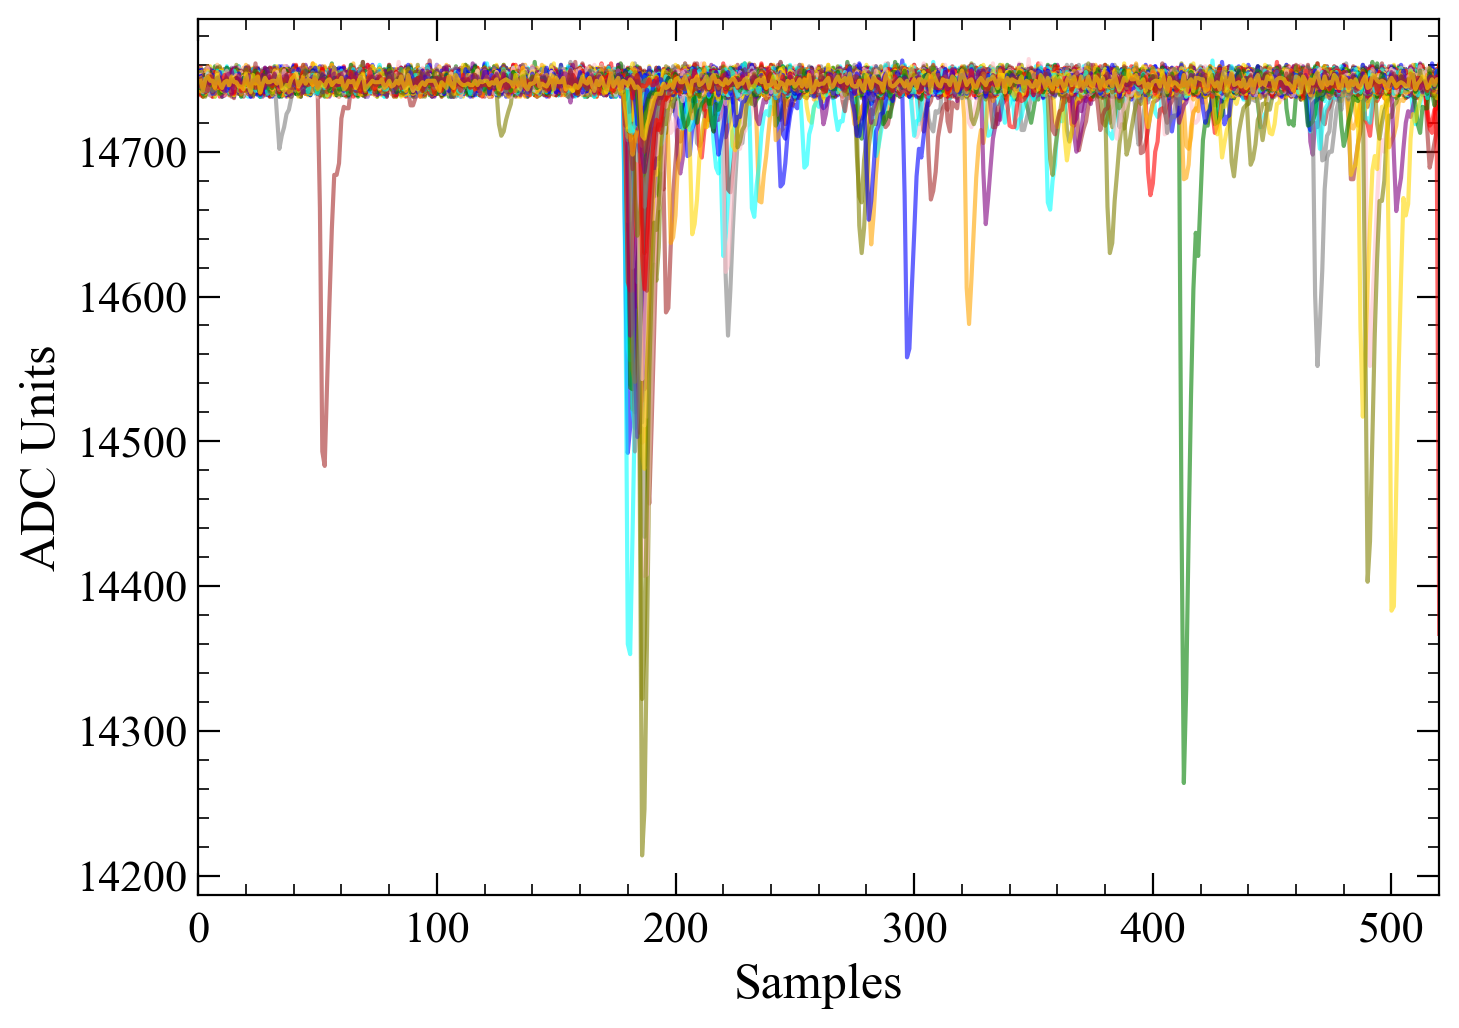

In [5]:
COLORS_LIST = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'gold', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots(1,1, dpi=200)

counter = 0
for idx, wf in enumerate(ch0_signals):

    if np.min(wf) > 14720:
        continue

    if counter+1 > len(COLORS_LIST):
        counter = 0

    ax.plot(sampleRange, wf, color=COLORS_LIST[counter], alpha=0.6, lw = 1.5, label=f'Event {idx}')

    counter += 1

ax.set_xlim(0., windowLength)
ax.set_xlabel('Samples')
ax.set_ylabel('ADC Units')
#ax.legend(frameon=False, loc='lower right', fontsize=12)

## Peak Finding and Intgral/Width Calculations

/var/folders/w0/n2ws7mw16vb_37jrv5hgk81h0000gn/T/ipykernel_72616/1448802421.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, dpi=200)


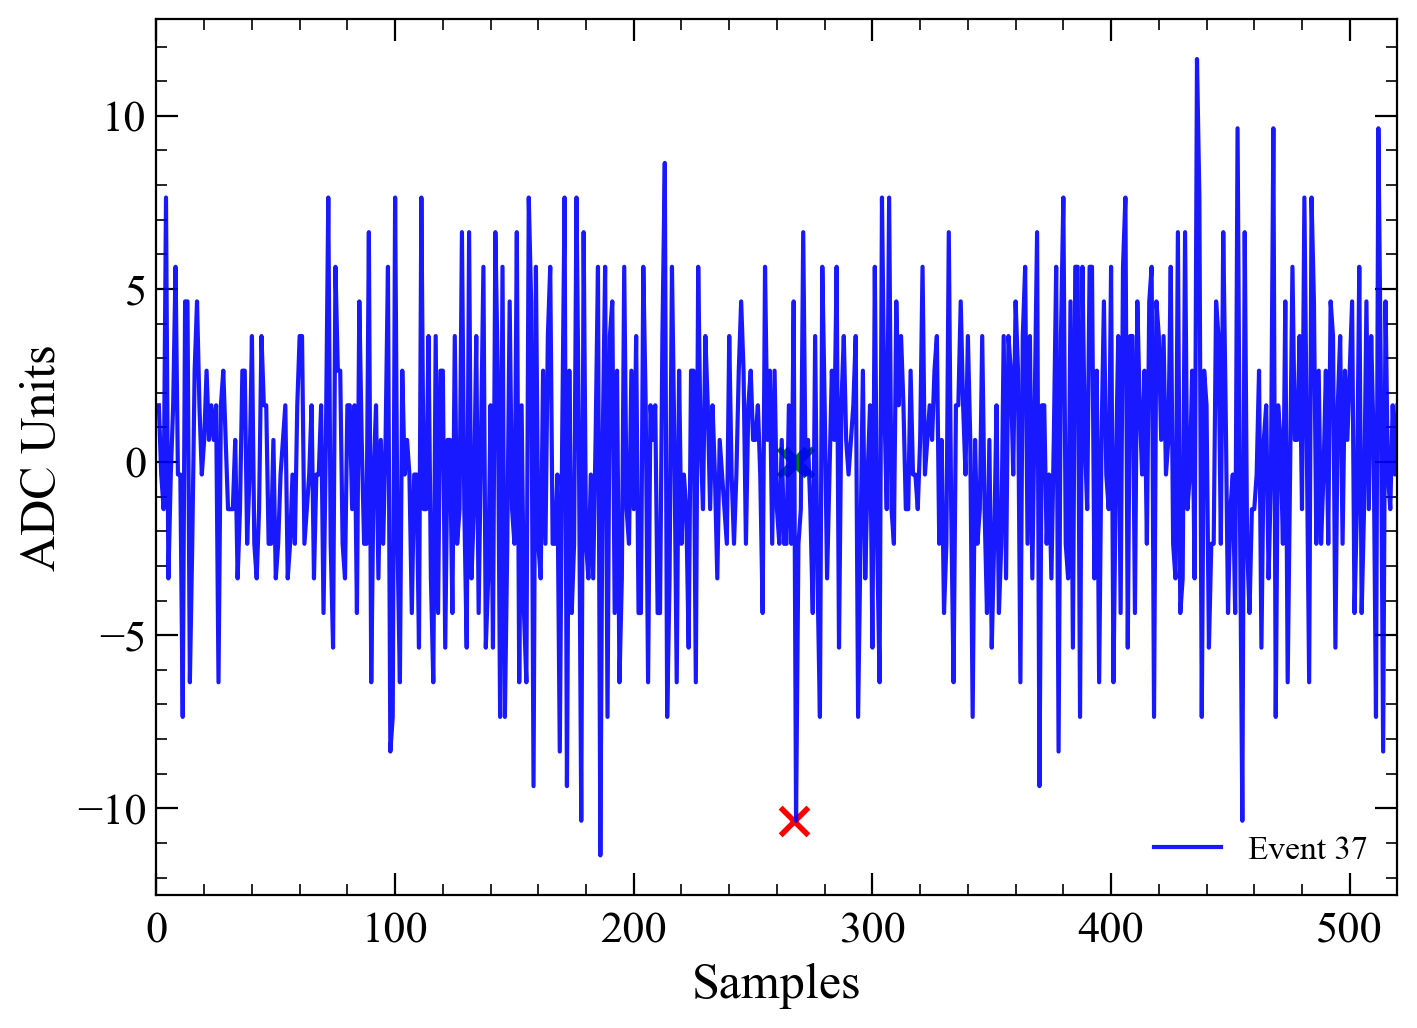

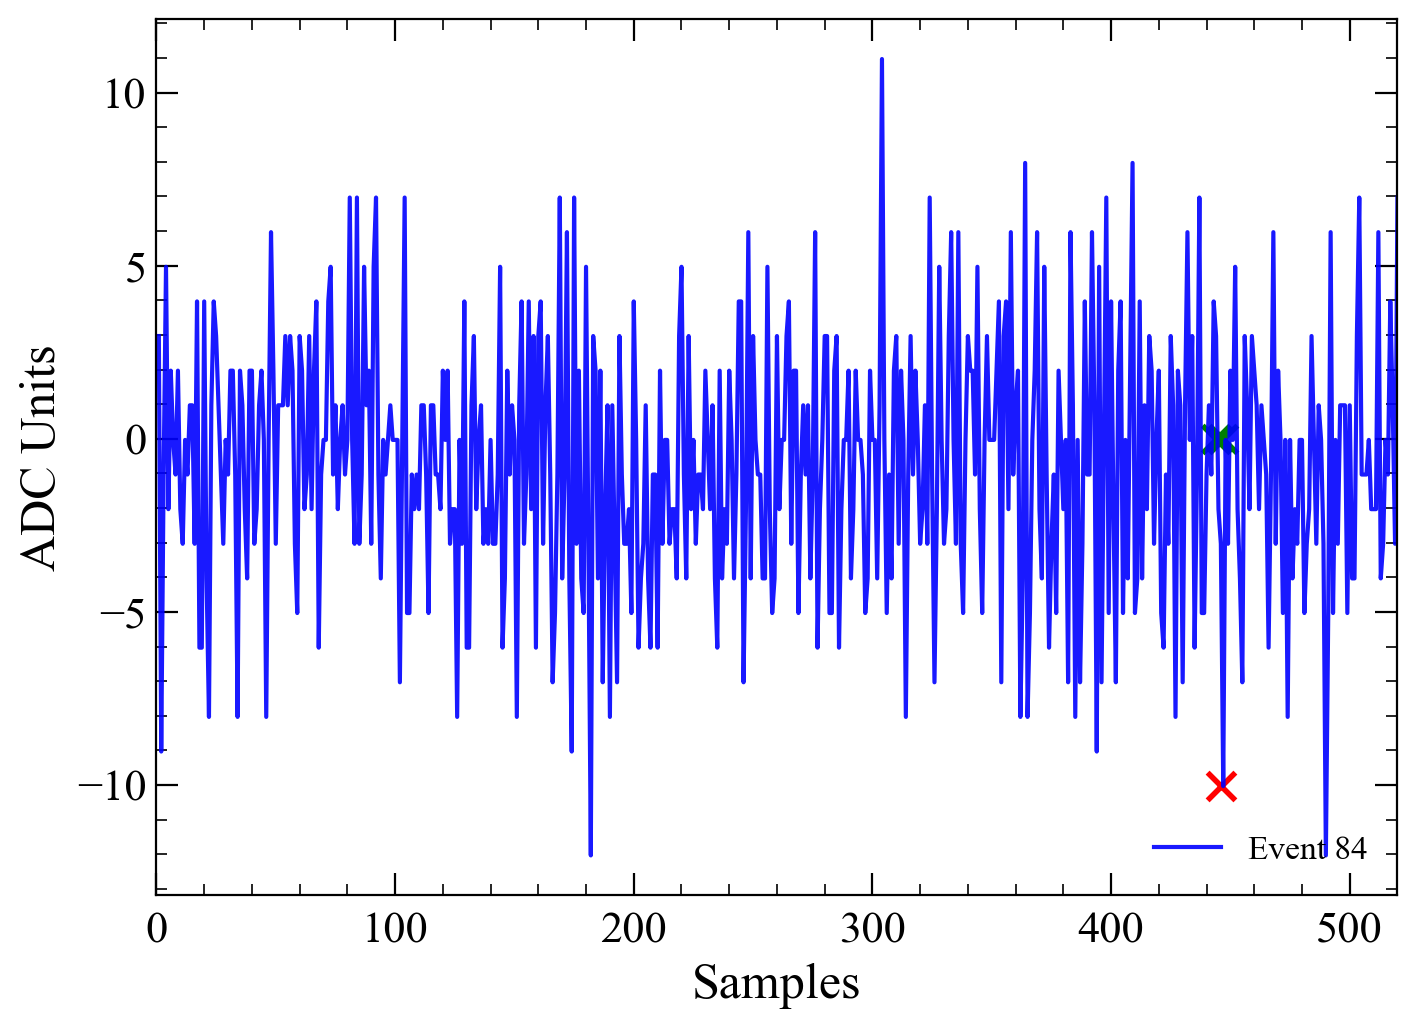

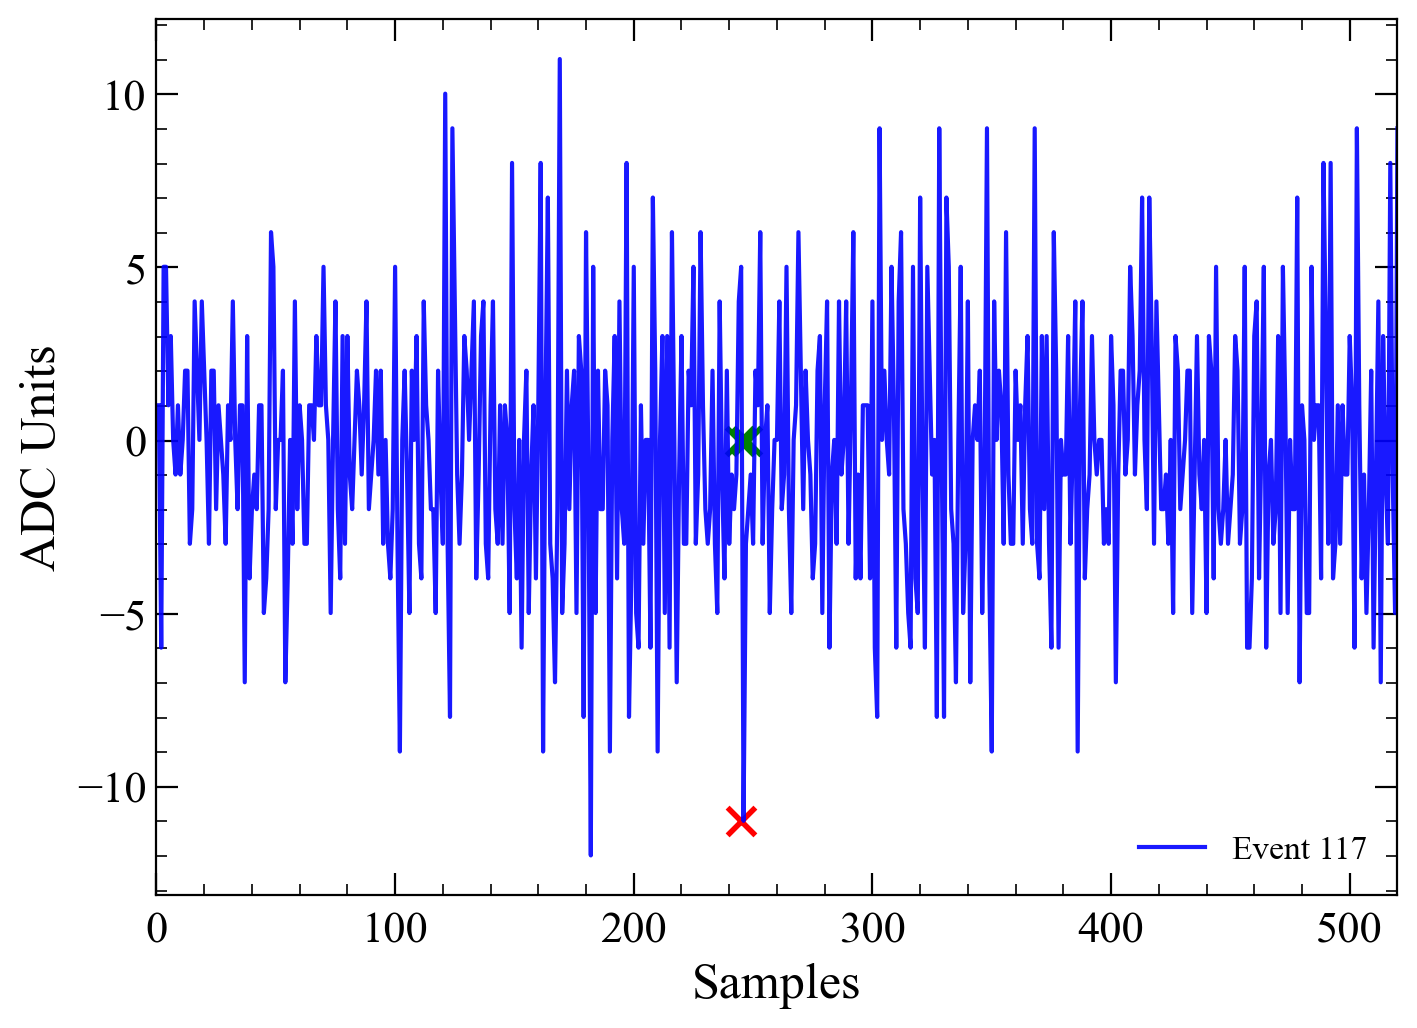

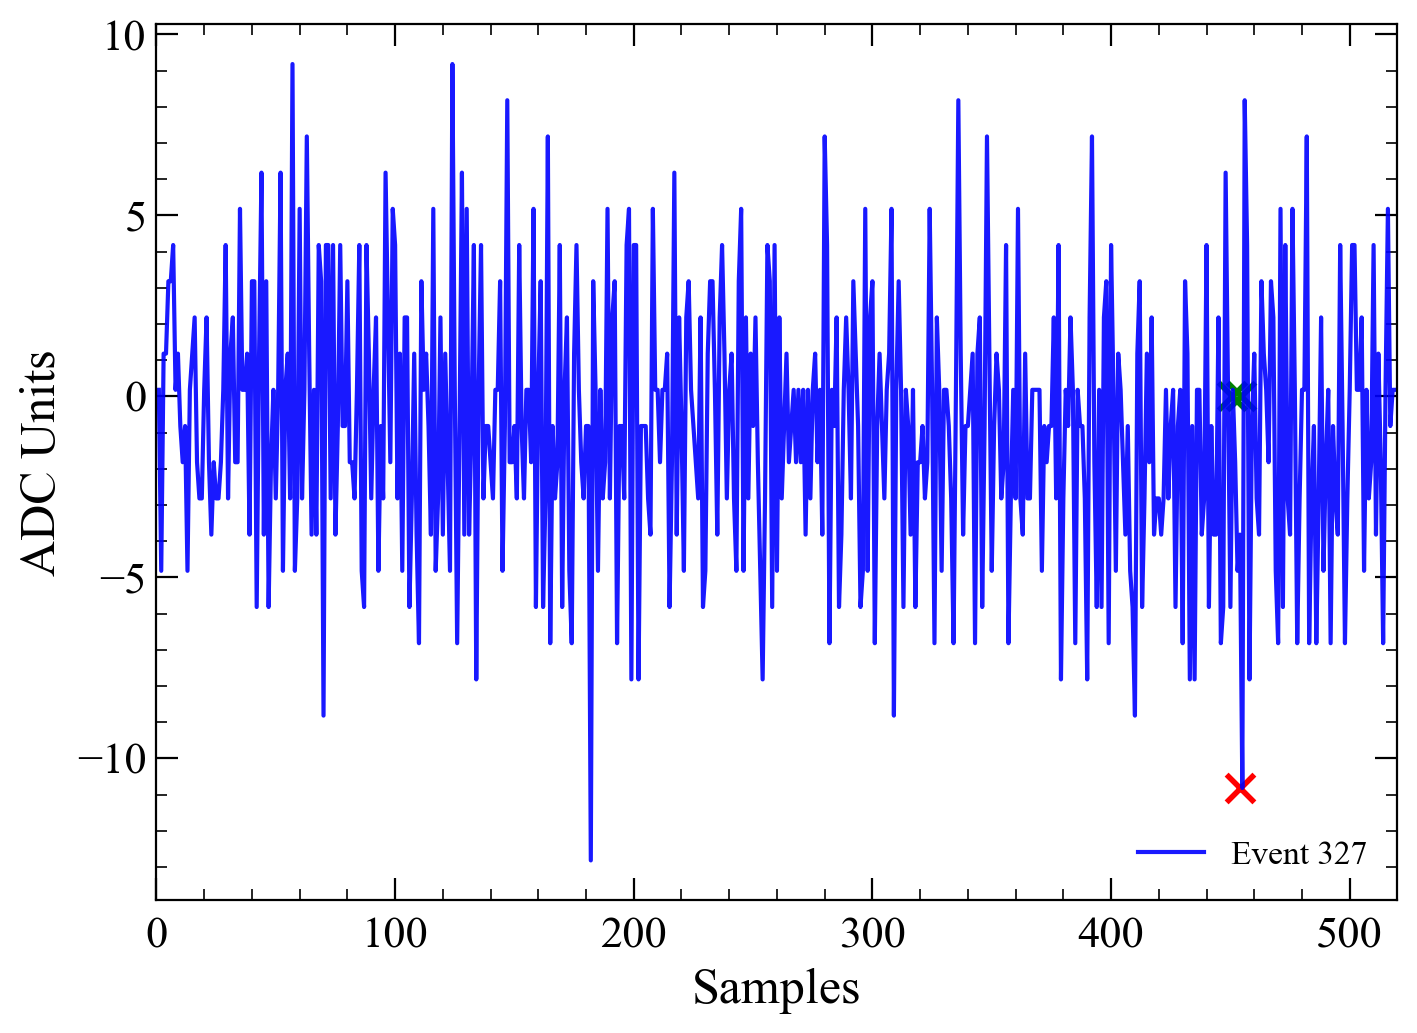

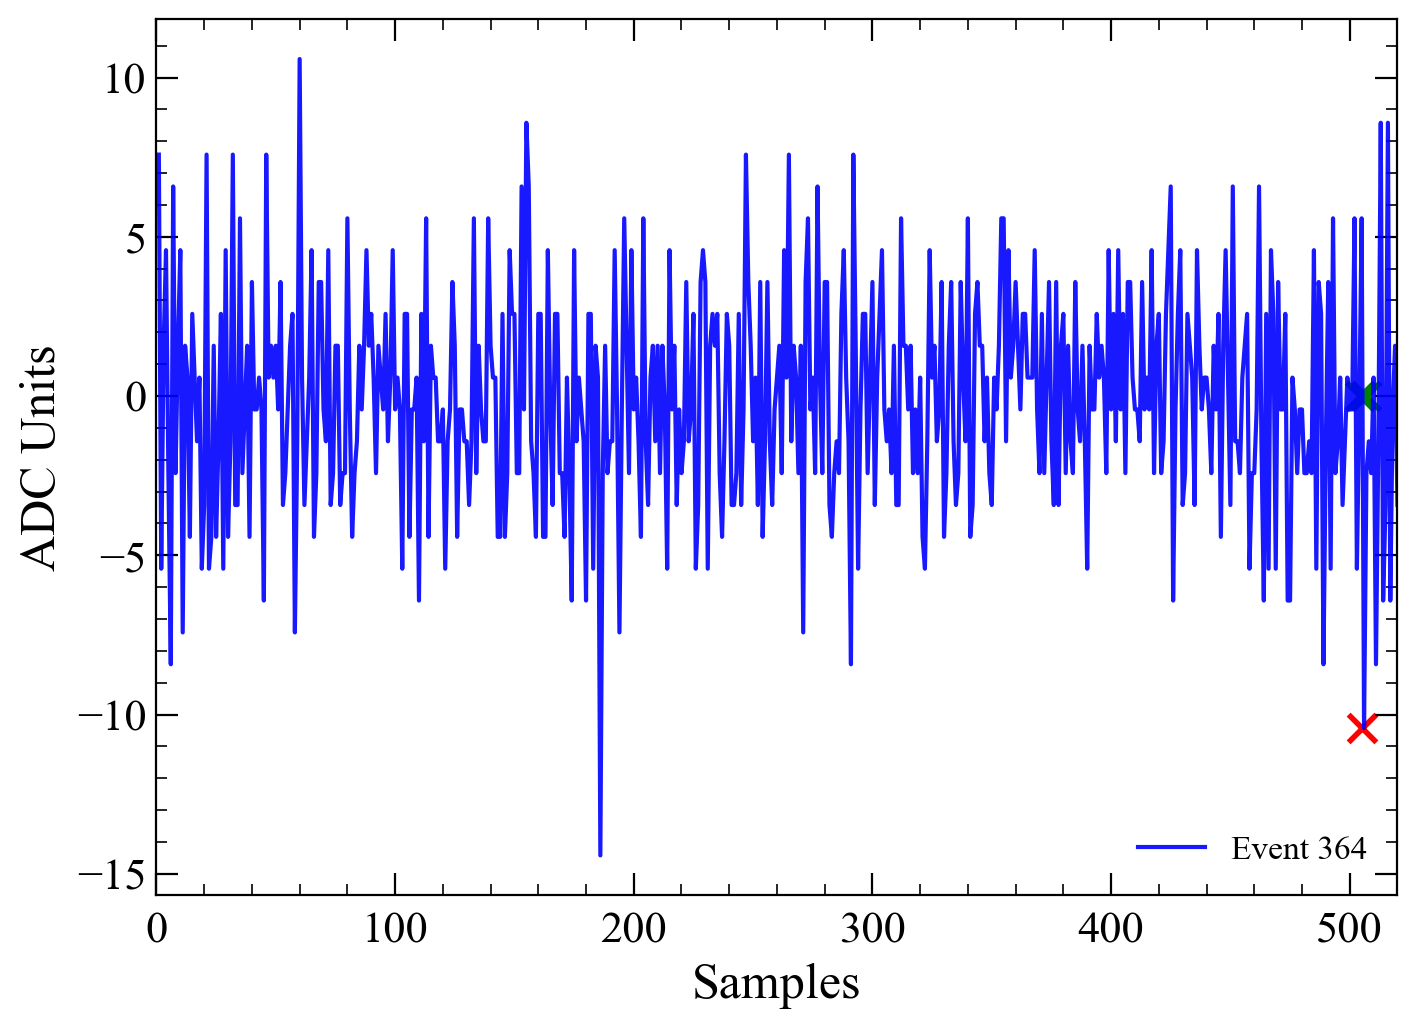

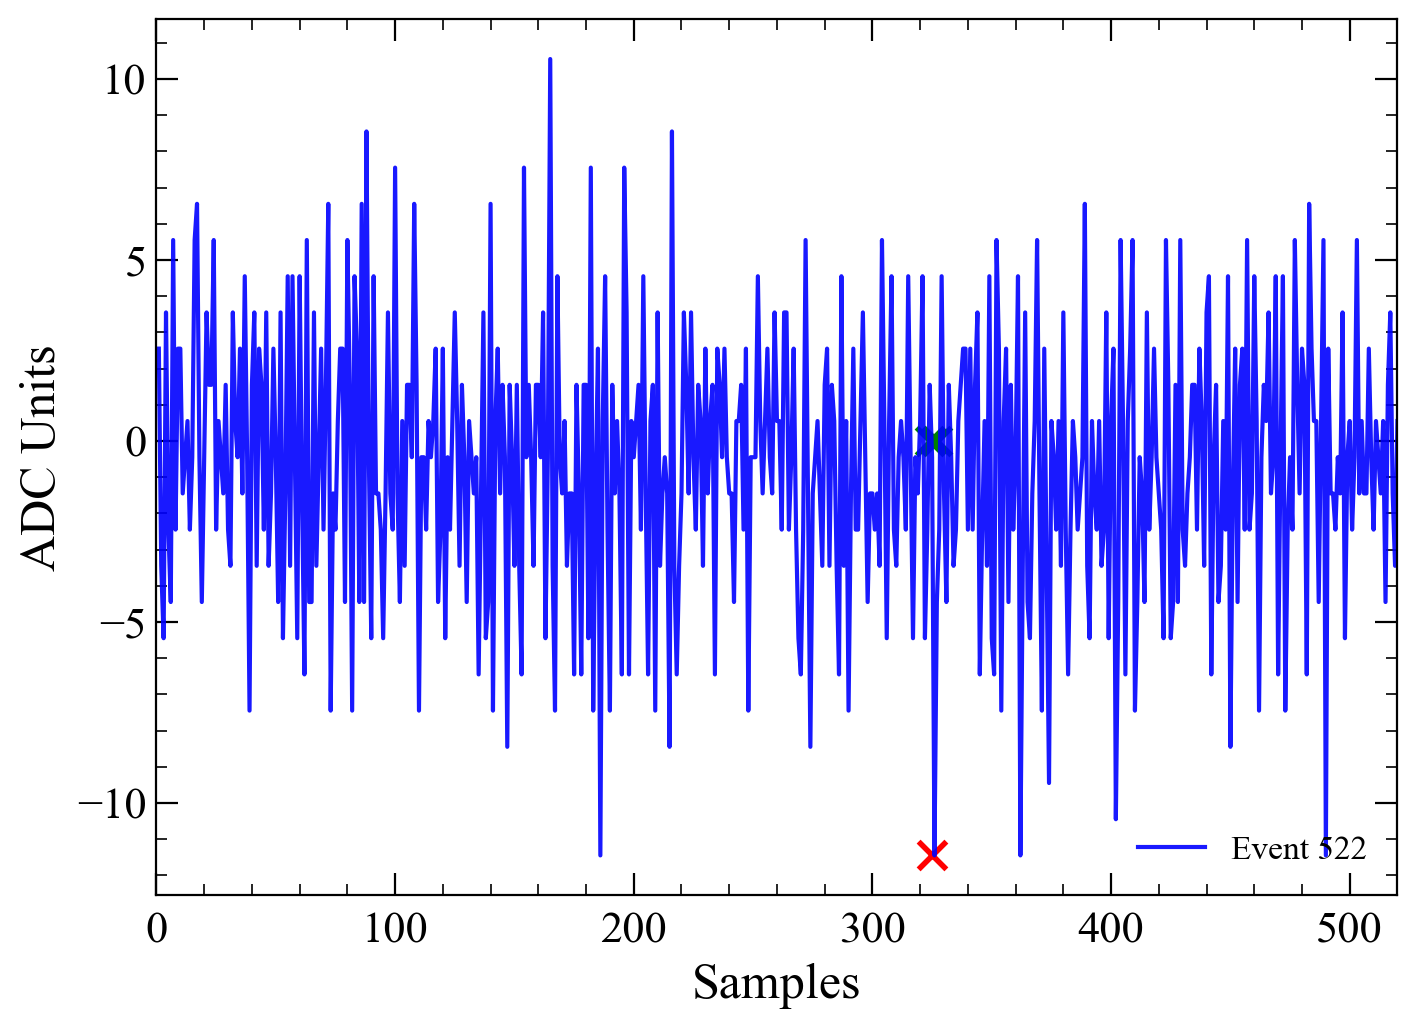

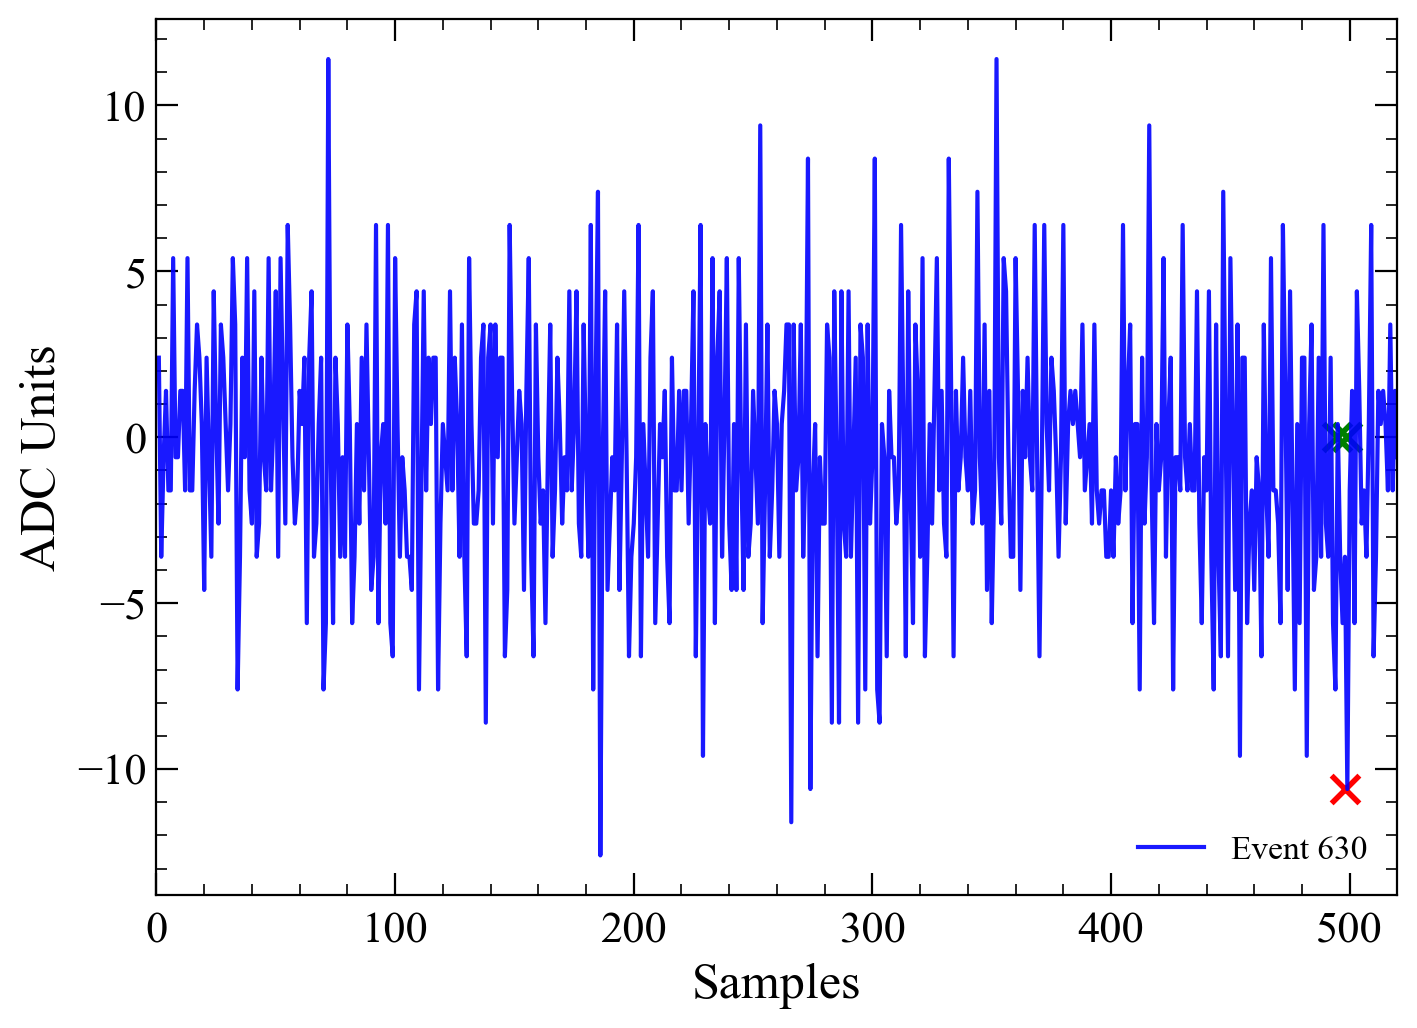

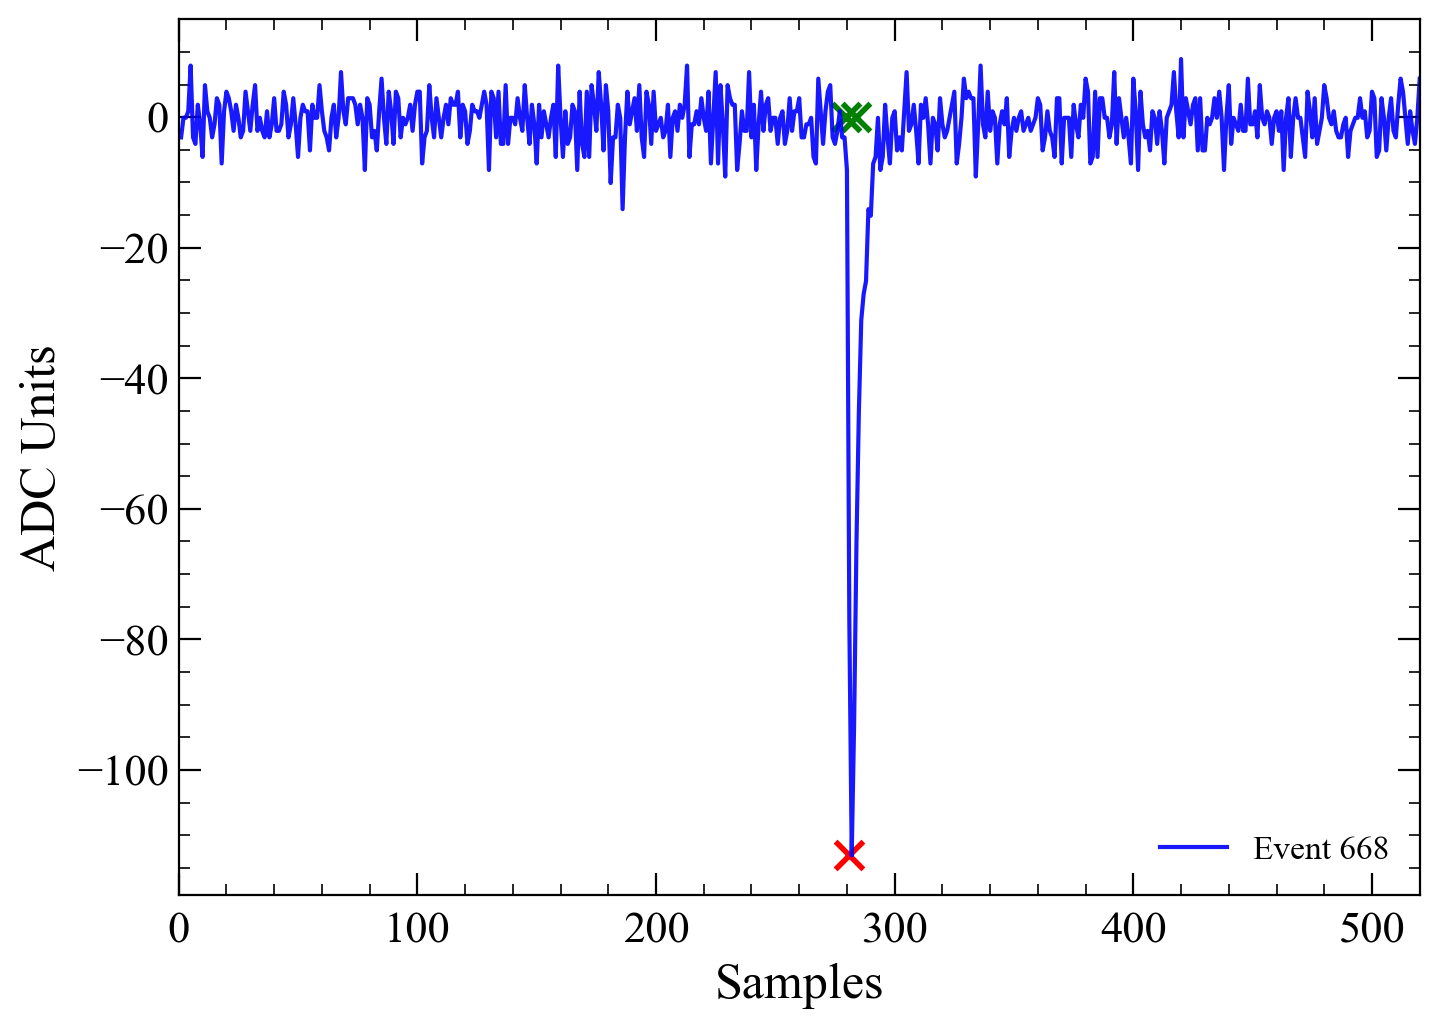

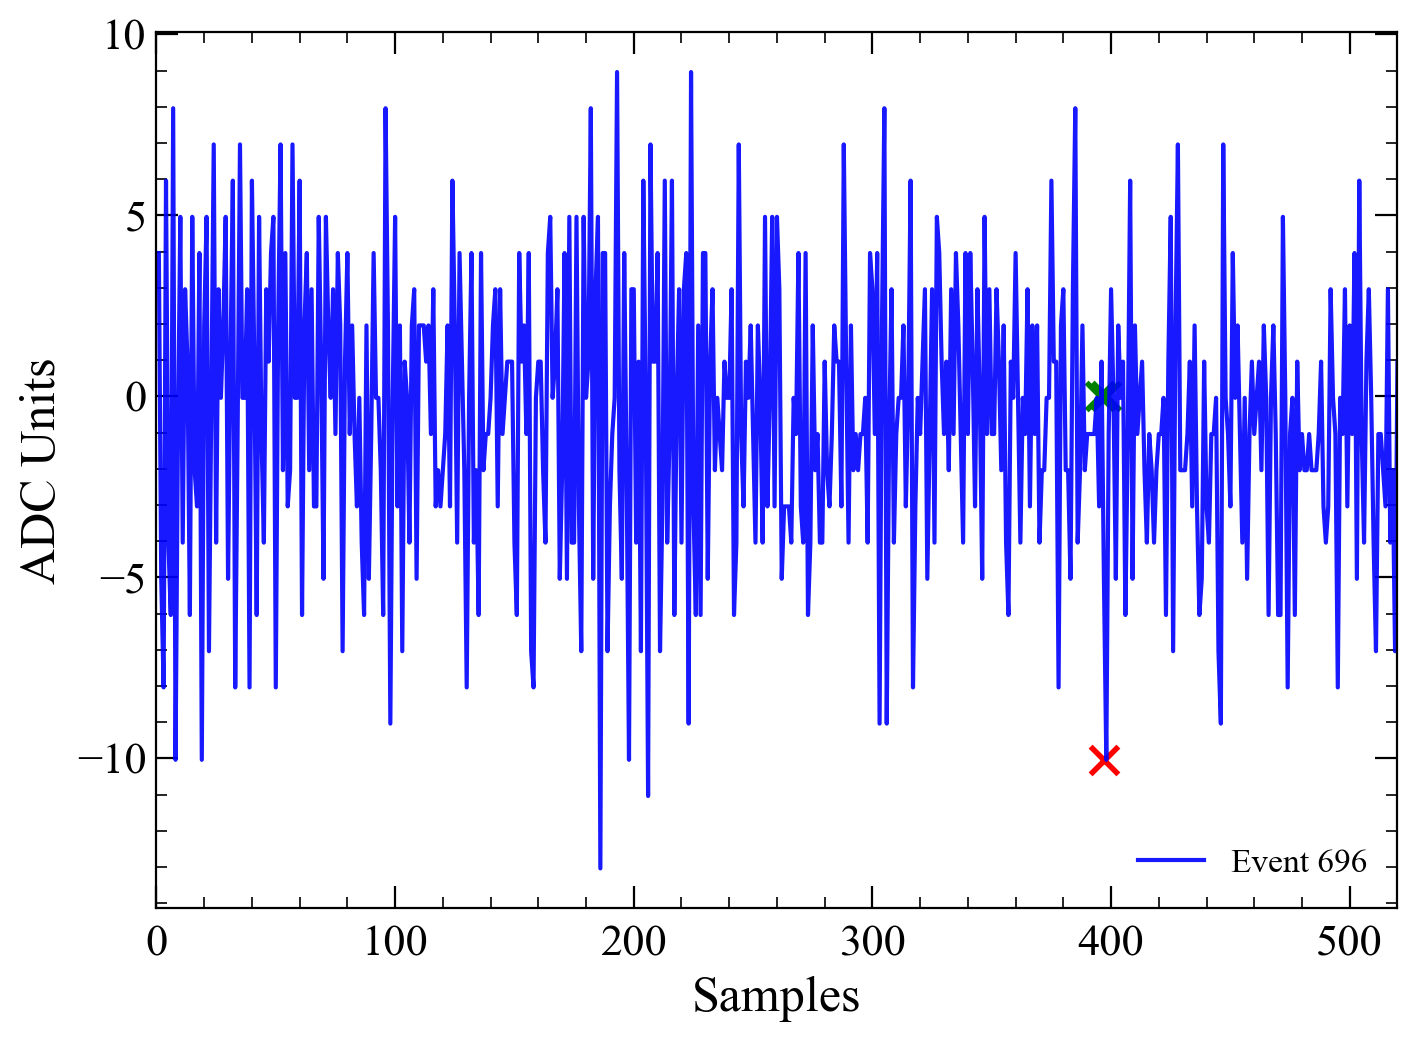

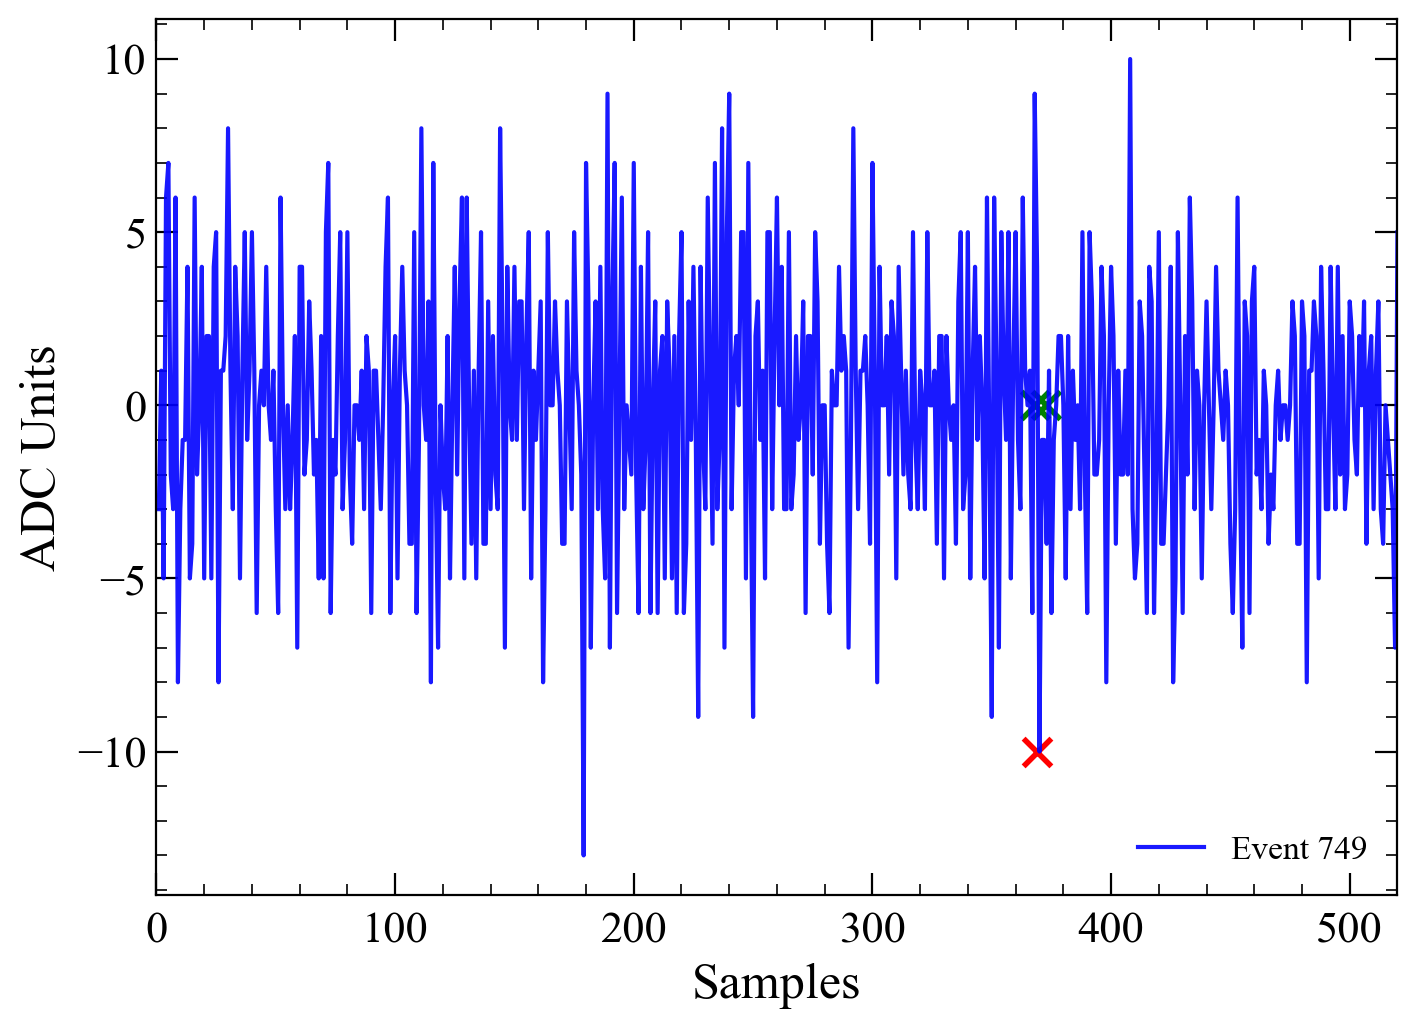

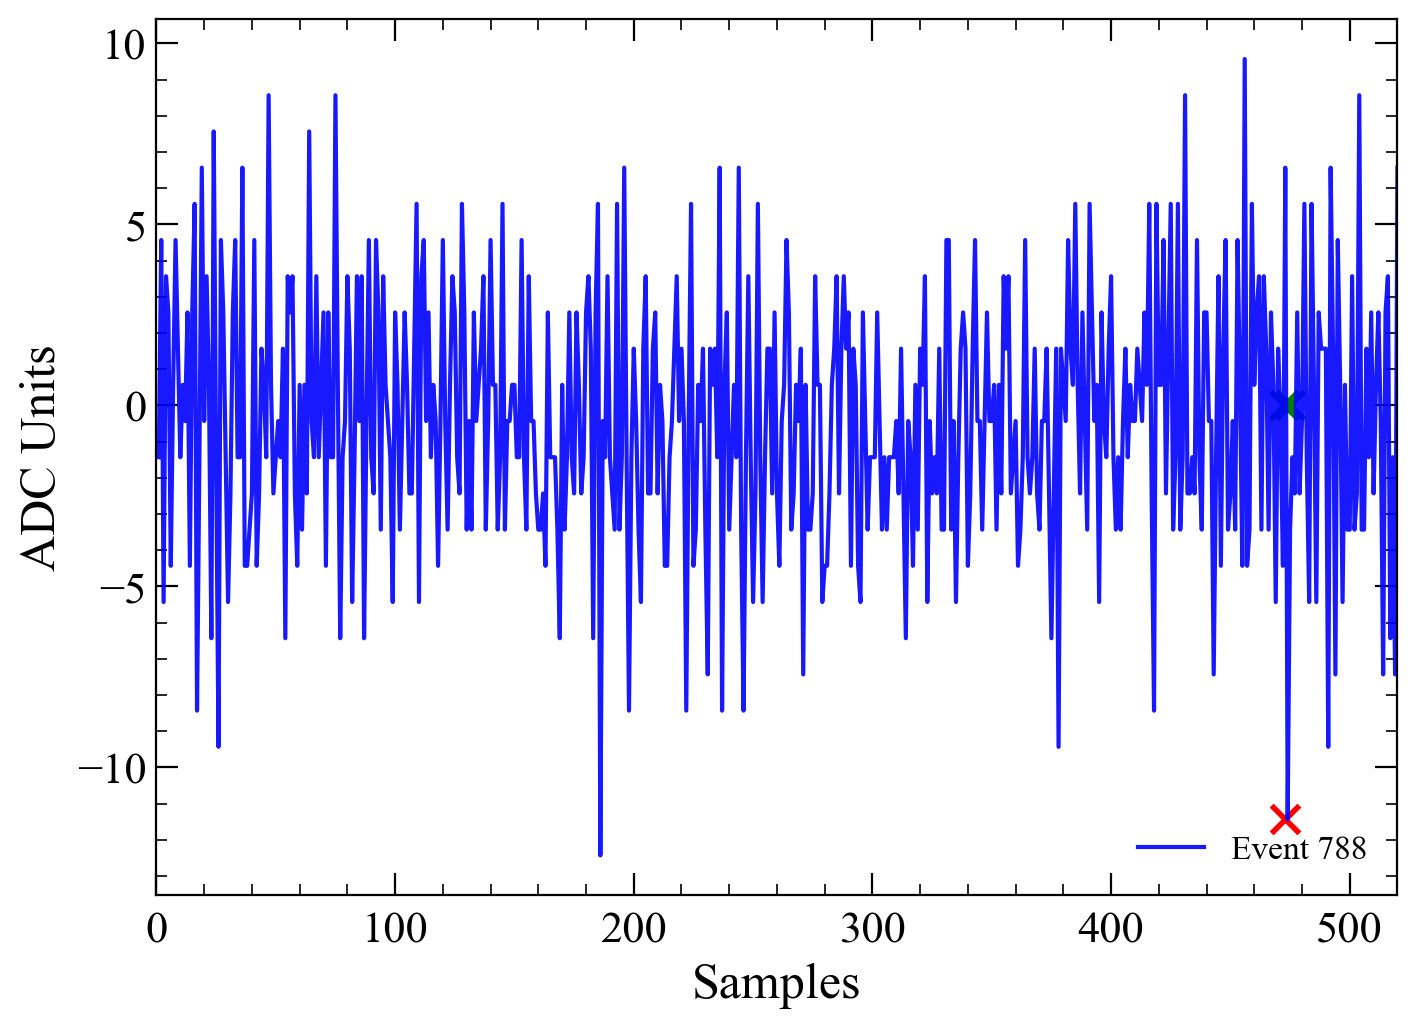

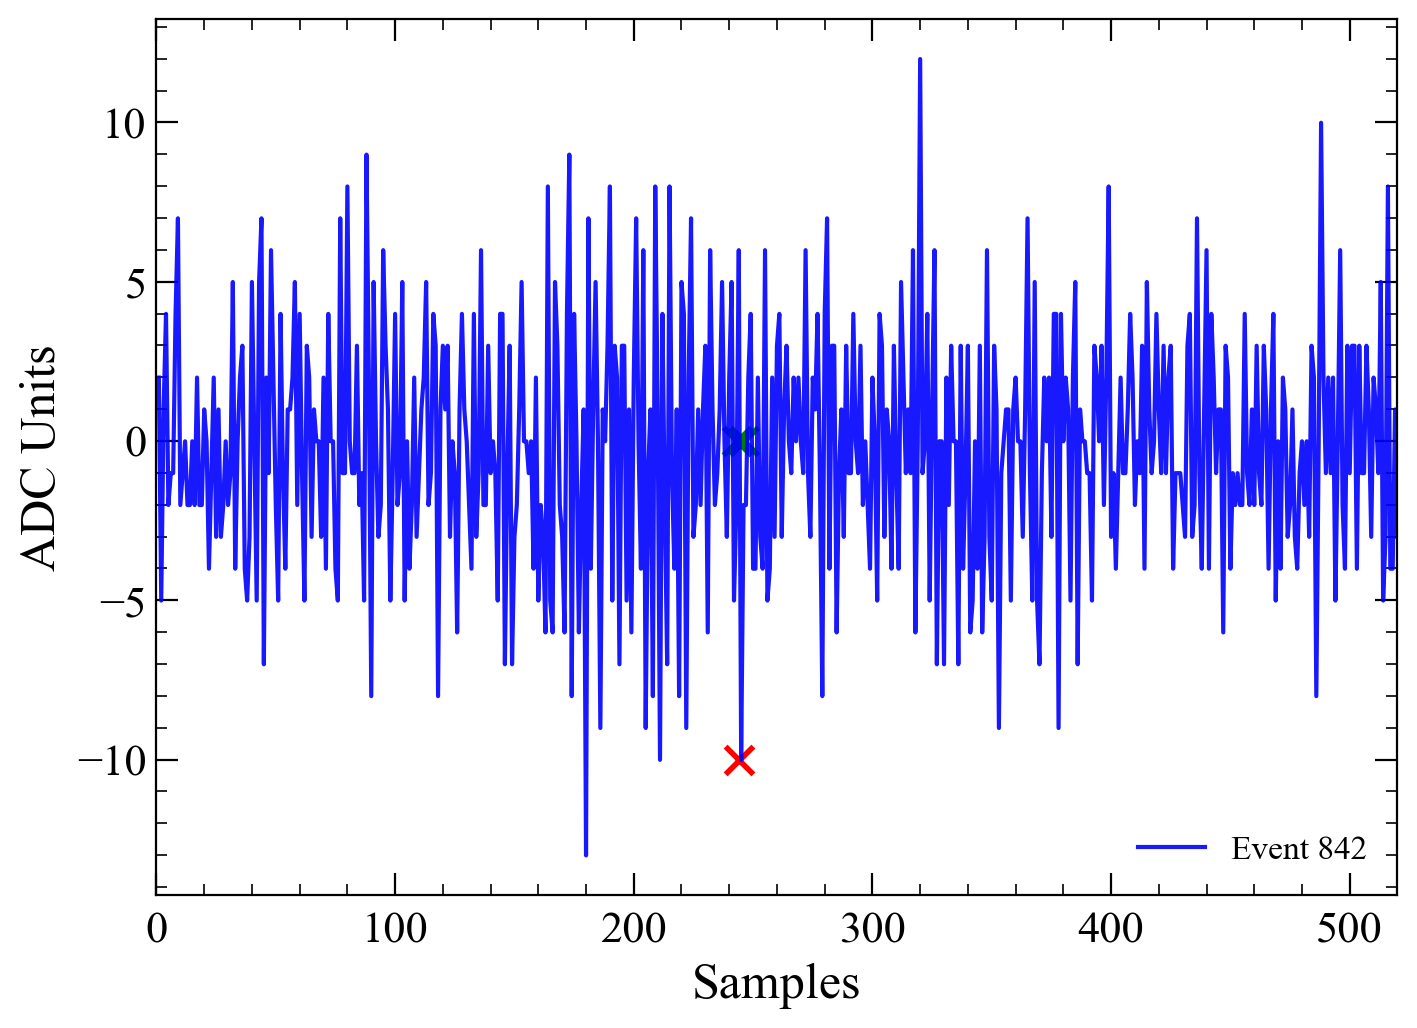

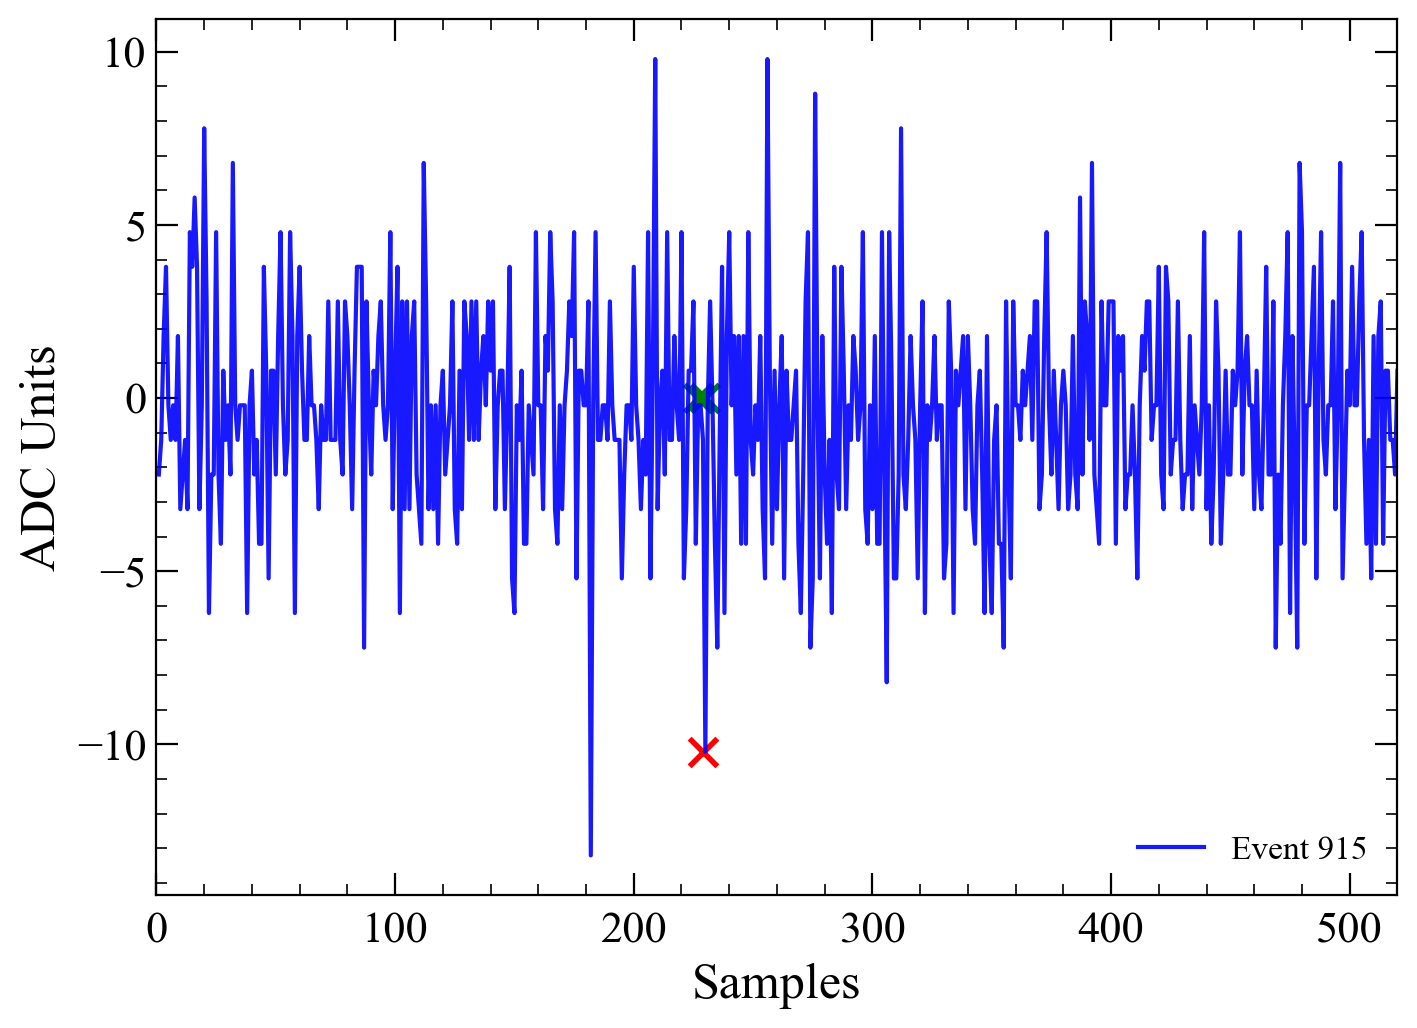

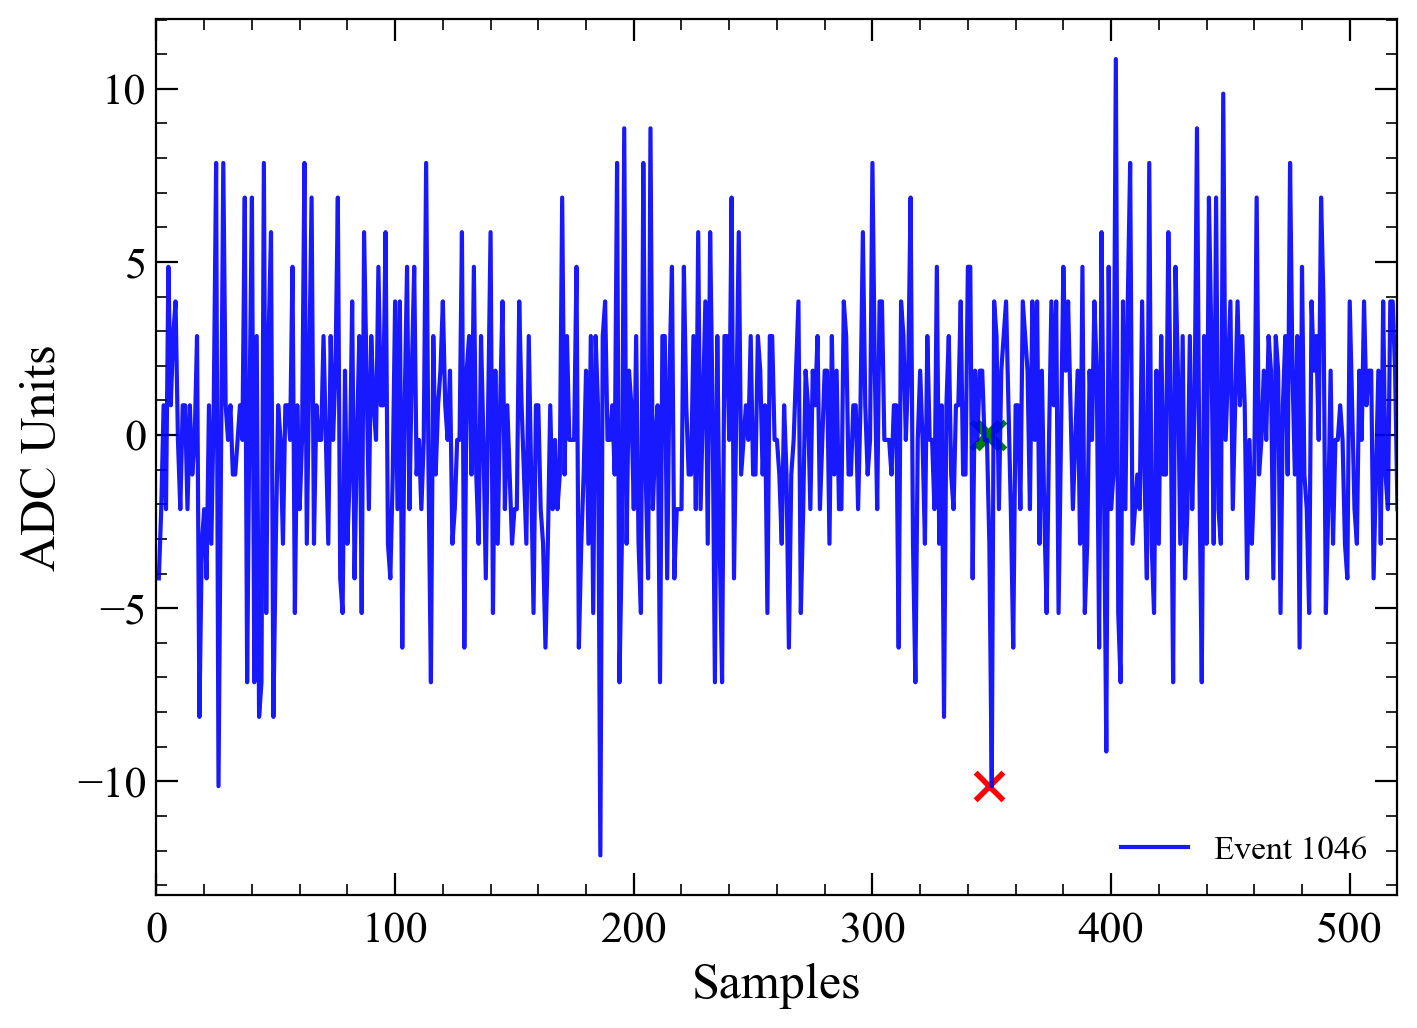

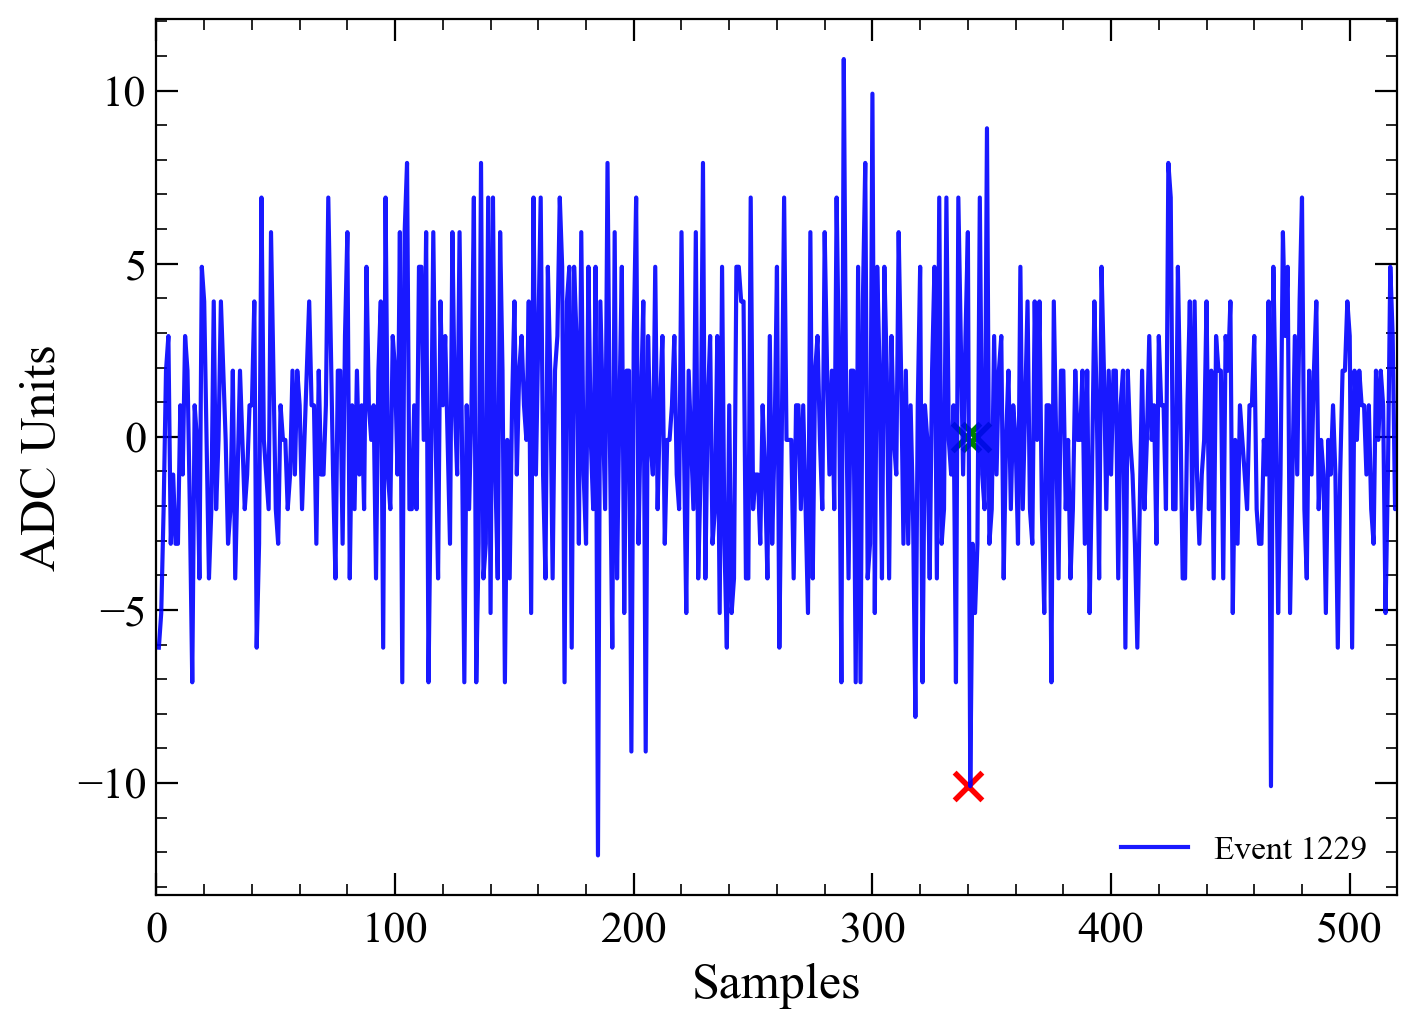

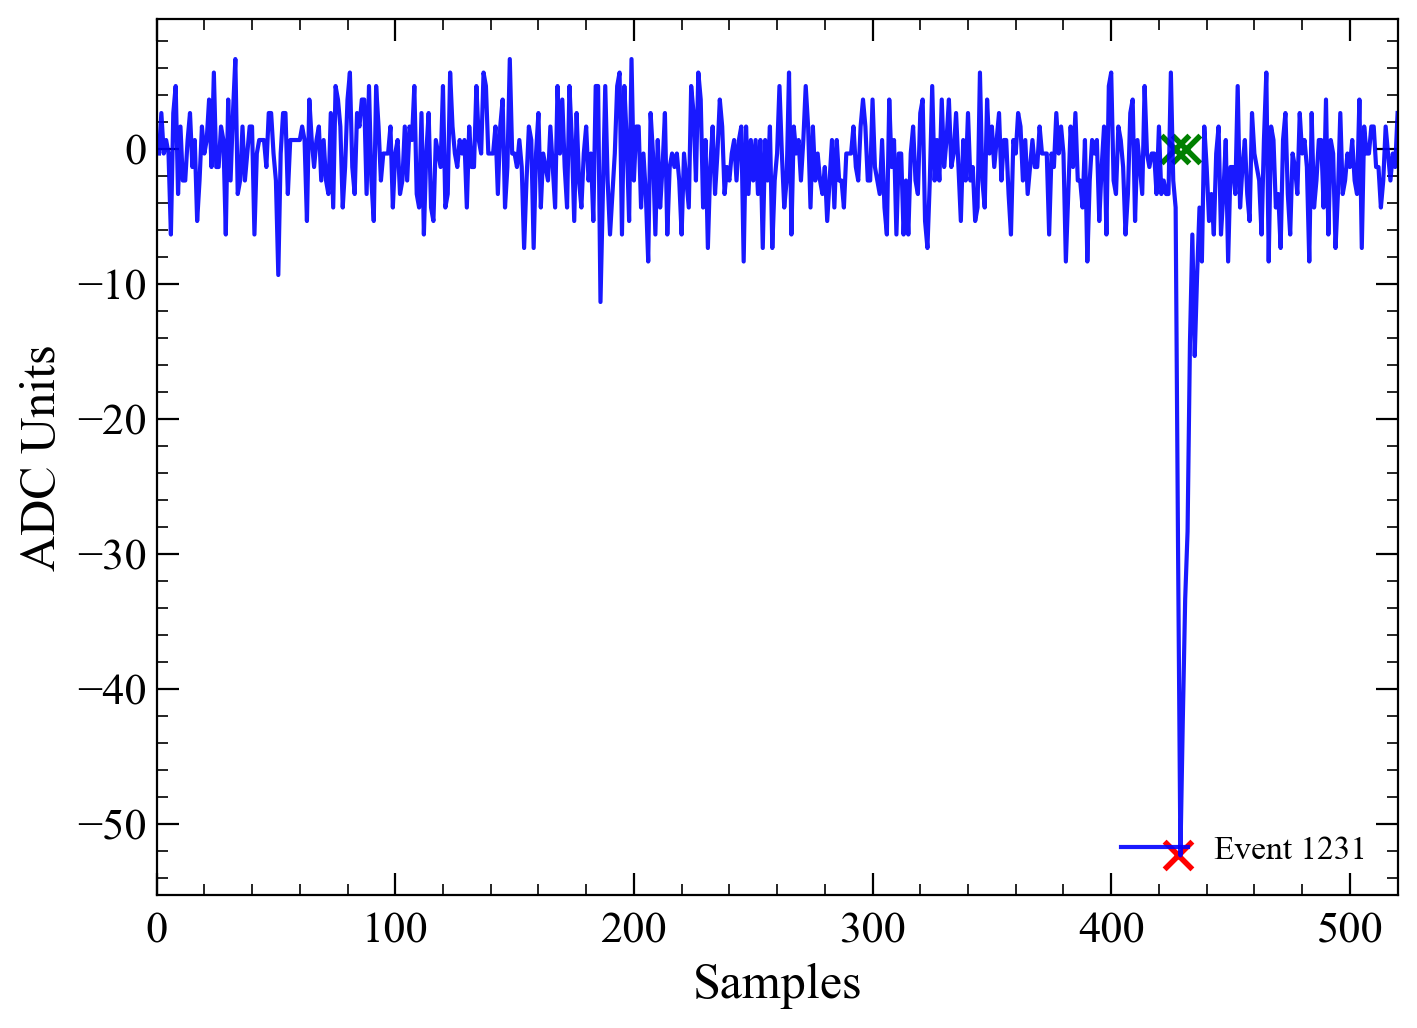

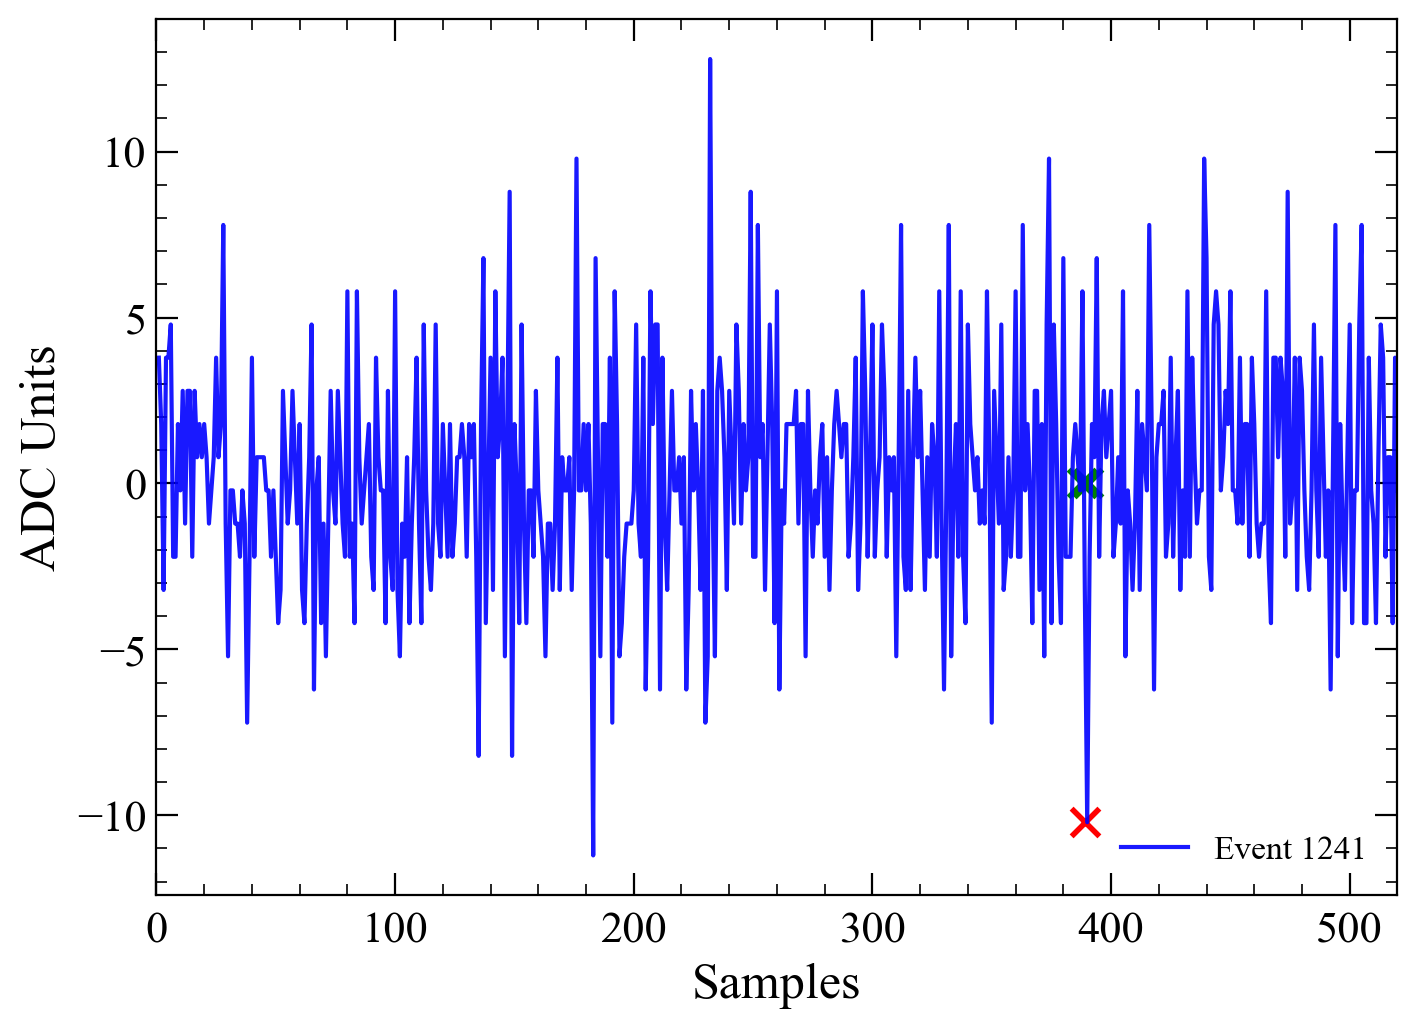

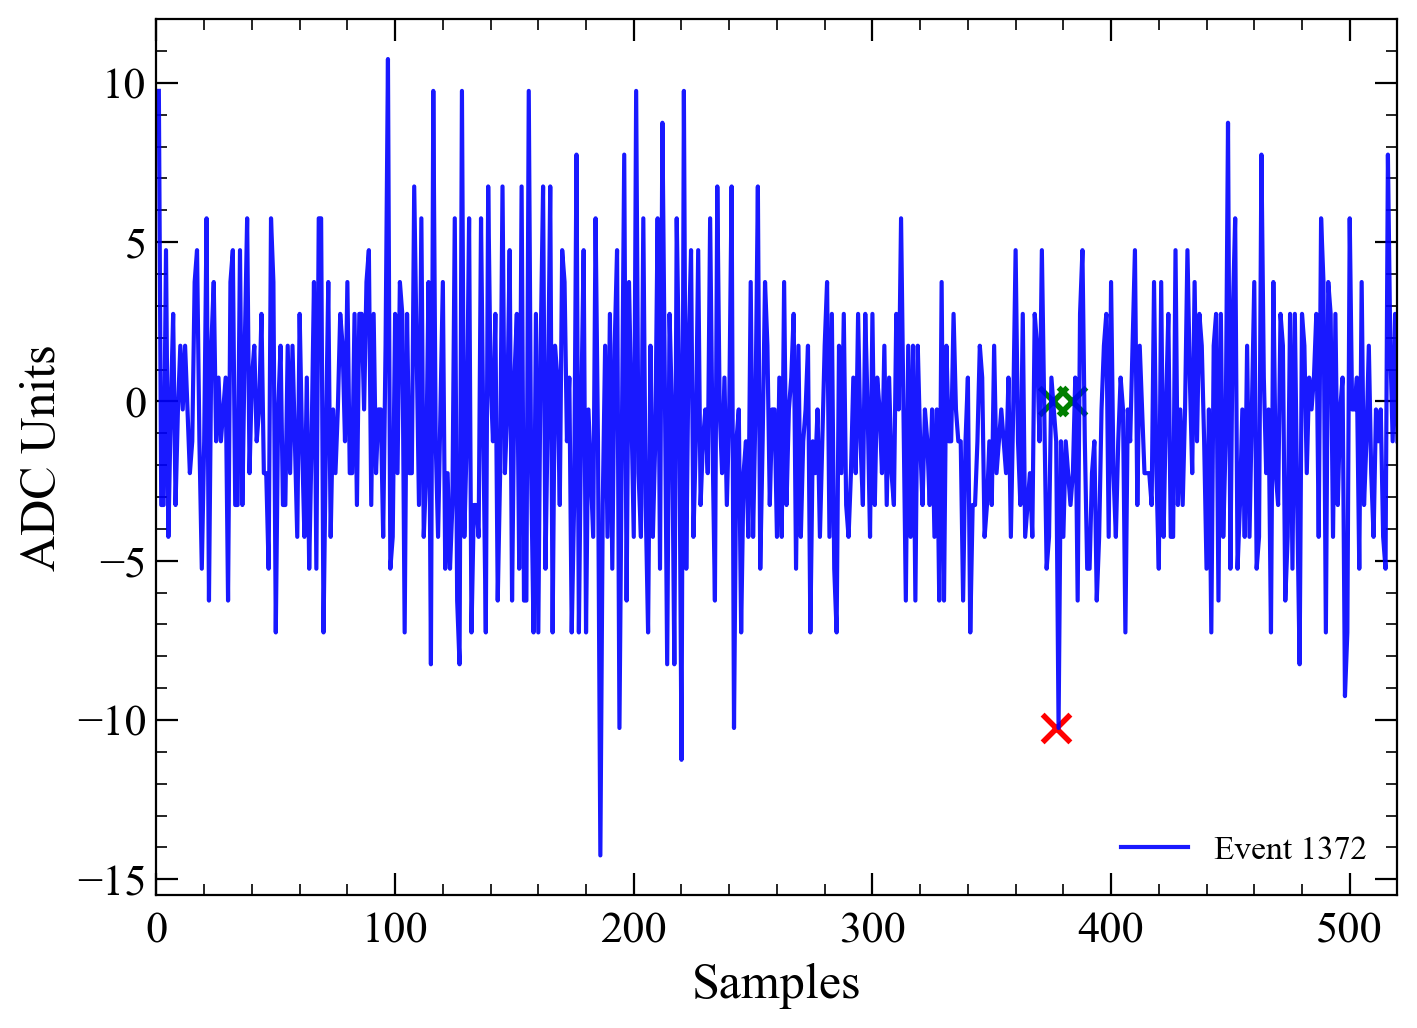

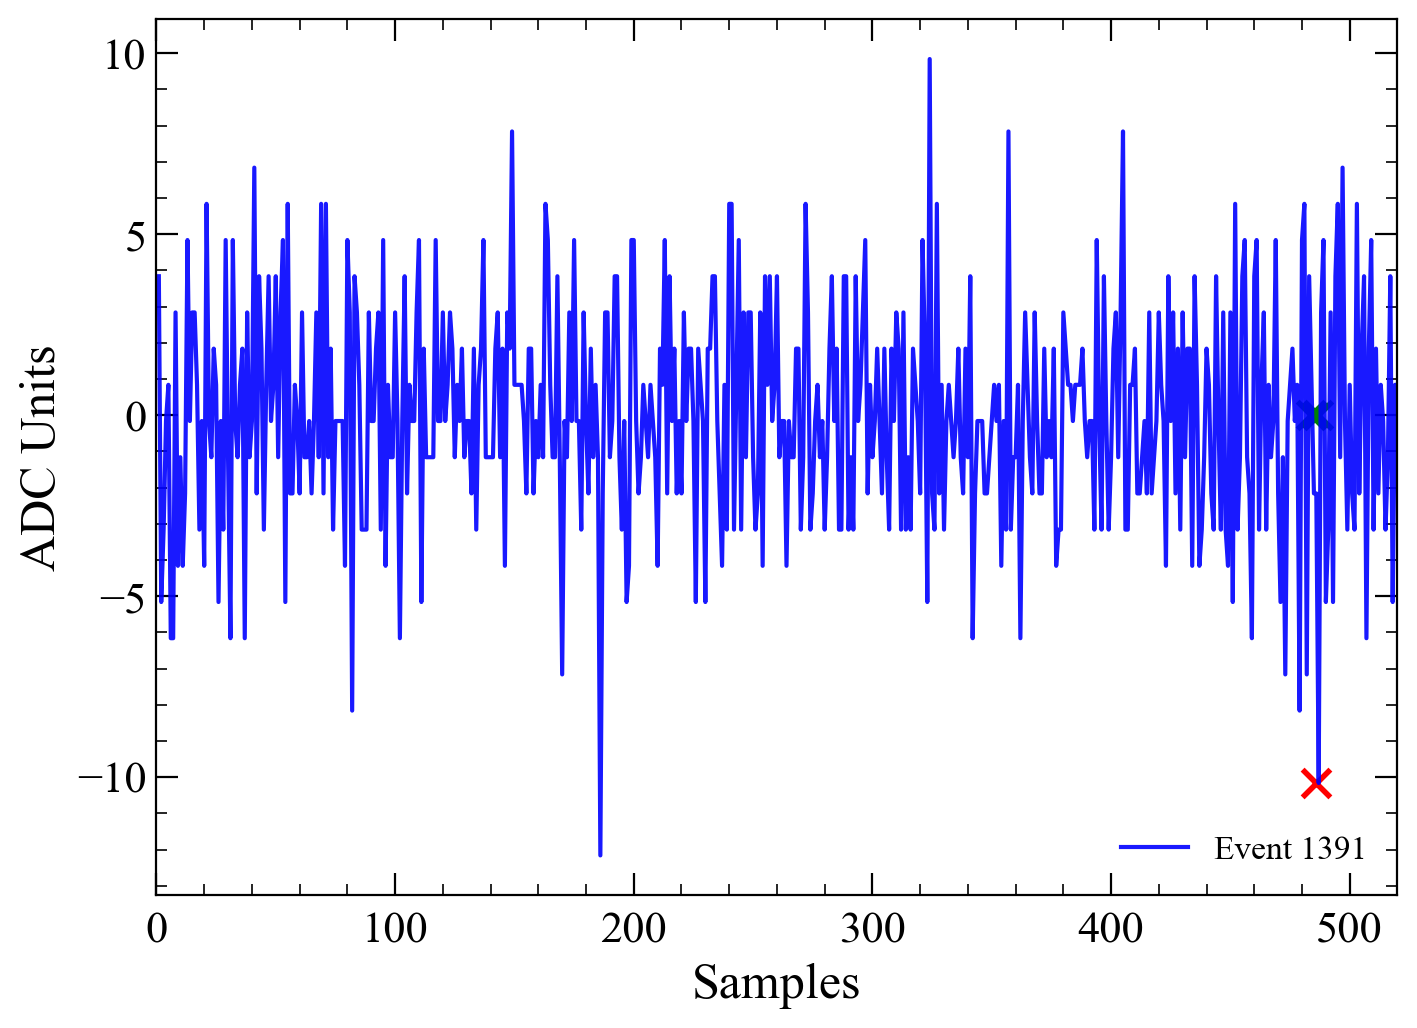

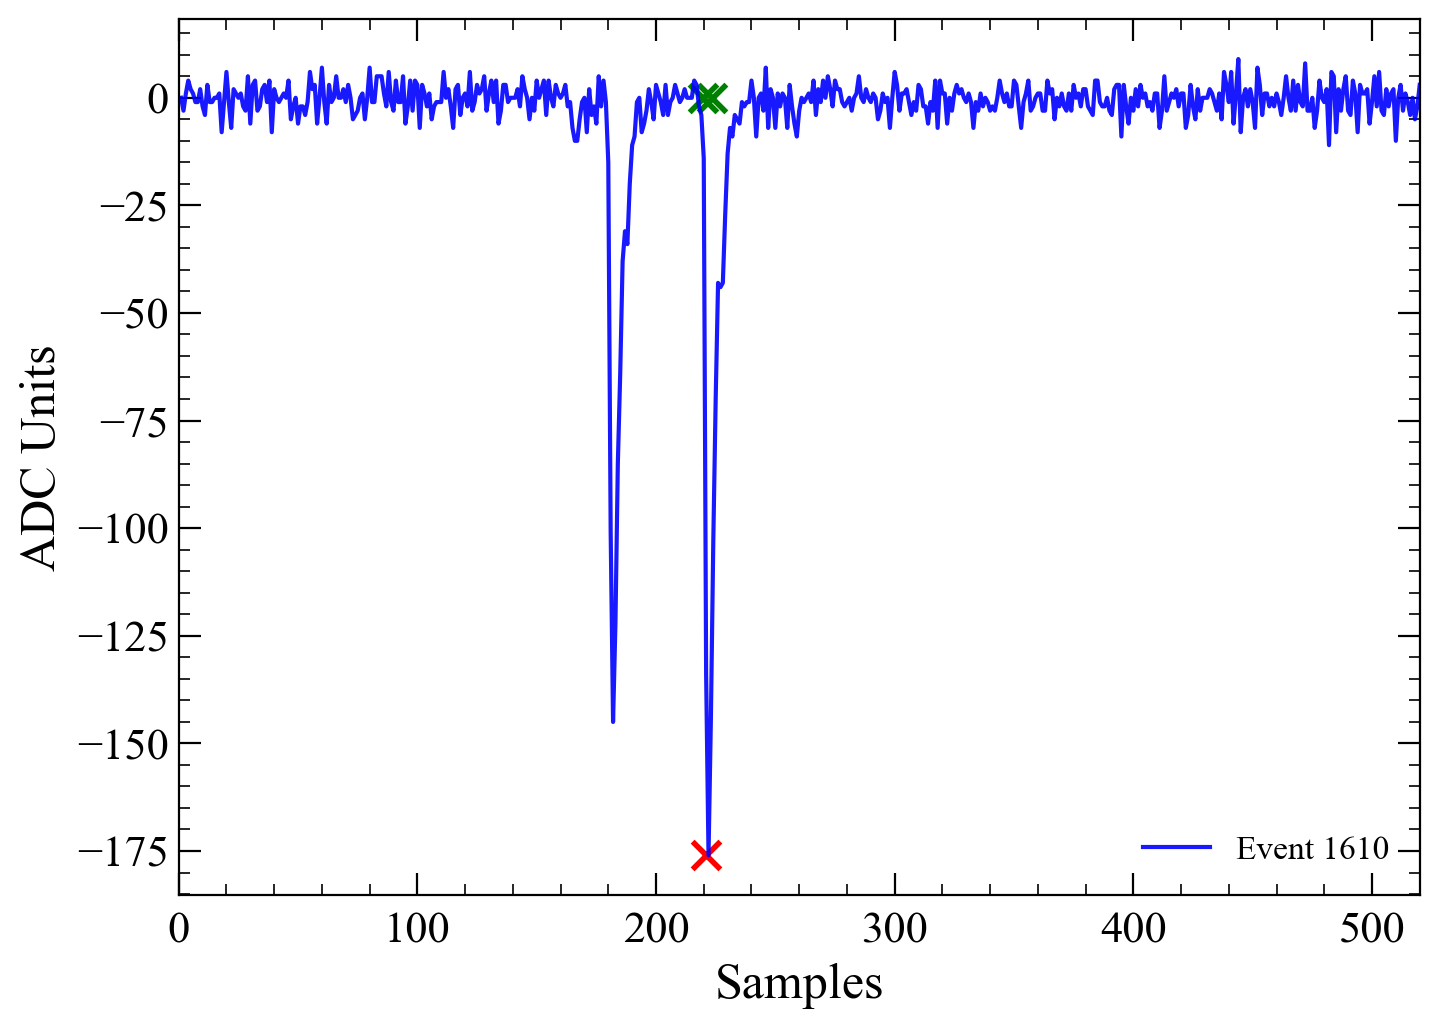

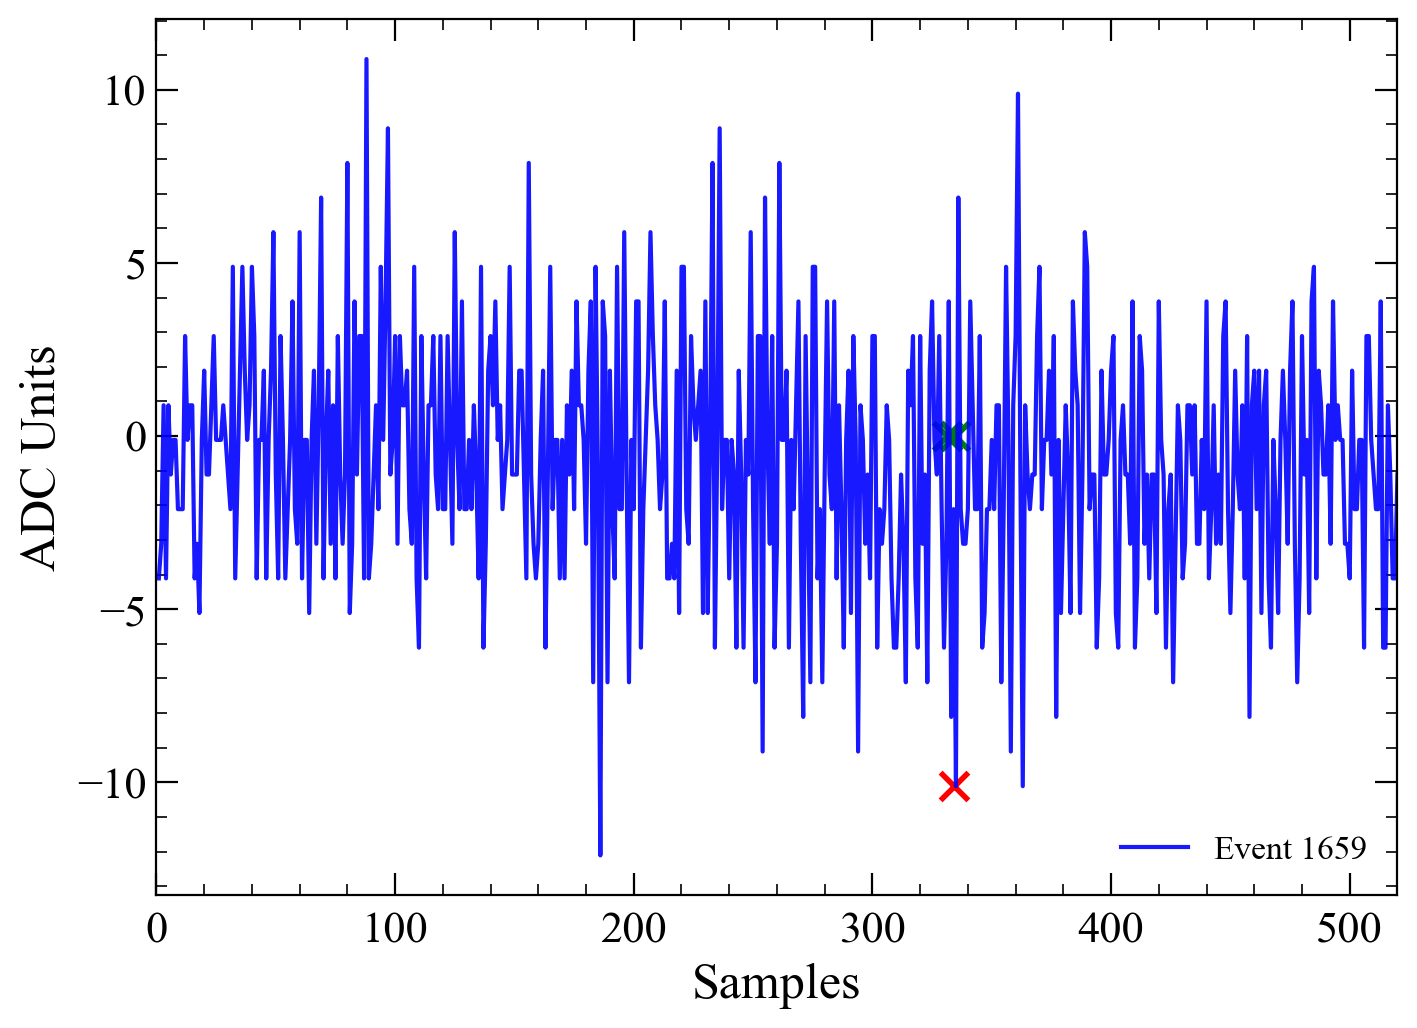

In [28]:
## --------------------- ##
##      USER INPUTS      ##
## --------------------- ##

## show plots
doPlot = True

## Max Number of plots to make
maxPlots = 20

## parameters for peak finding
## Note RMS of noise is ~ 5 ADC
height = 10
width = 2.5
threshold = 1 

## -------------------------------------- ##
##              PROCESSING                ##
## -------------------------------------- ##

## Store values for triggered pulses
Noises, Baselines, Heights_trig, Areas_trig, Lengths_trig = [], [], [], [], []

## Store same values for signals in post-trigger window
Heights_posttrig, Areas_posttrig, Lengths_posttrig = [], [], []

nPlots = 0

for idx, wf in enumerate(ch0_signals):

    ## turn off plotting after making enough
    if nPlots > maxPlots:
        doPlot = False

    ## this function kinda sucks
    ## use peakutils function to calculate baseline
    #bLine = peakutils.baseline(np.array(wf),0)

    ## find the baseline using mean of wf before trigger
    baseline = np.mean(wf[:100])

    ## get the noise level
    noise = np.std(wf[:100])

    ## Now use scipy to find the peak
    ## lots of options to set height, width, prominence, threshold
    ## use minimum height and must be 2 samples wide
    ## gotta flip the polarity for this too
    peaks, properties = scipy.signal.find_peaks(-1*np.array(wf-baseline), height=height, width=width, threshold=threshold)

    ## calculate pulse boundaries using FWHM
    peakLength = scipy.signal.peak_widths(-1*np.array(wf-baseline), peaks, rel_height=0.5)

    ## If no peaks found, move on, get over it
    if len(peaks) == 0:
        continue

    goodEvent = False
    ## Loop through peaks found
    for jdx in range(len(peaks)):

        goodEvent = False

        ## get peak height
        peakHeight = properties['peak_heights'][jdx]

        ## pulse fwhm in samples
        fwhm_lenth = peakLength[jdx][0]

        # Get min/max pulse boundaries 
        pulseMin = np.floor(peakLength[2][jdx])
        pulseMax = np.ceil(peakLength[3][jdx])

        ## Do integral of baseline subtracted wf in 2*FWHM
        region = (sampleRange >= peaks[jdx]-3*fwhm_lenth) & (sampleRange <= peaks[jdx]+3*fwhm_lenth)
        area = scipy.integrate.trapz(-1*np.array(wf-baseline)[region])

        ## focus on triggered peaks first
        if peaks[jdx] > 175 and peaks[jdx] > 215:
            ## store widths value
            Lengths_trig.append(peakLength[3][jdx]-peakLength[2][jdx])
            ## store areas
            Areas_trig.append(area)
            ## store heights
            Heights_trig.append(peakHeight)
            goodEvent = True
        ## Store post trigger window
        if peaks[jdx] > 230:
            Lengths_posttrig.append(peakLength[3][jdx]-peakLength[2][jdx])
            Areas_posttrig.append(area)
            Heights_posttrig.append(peakHeight)
            goodEvent = True

        ## Plot the peak and peak length...
        if doPlot and goodEvent:
            nPlots += 1
            fig, ax = plt.subplots(1,1, dpi=200)
            ax.plot(sampleRange, wf-baseline, color='blue', alpha=0.9, lw = 1.5, label=f'Event {idx}')
            ax.scatter(peaks[jdx], -1*properties['peak_heights'][jdx], marker='x', color='red')
            ax.scatter(peakLength[2][jdx], 0.,  marker='x', color='green')
            ax.scatter(peakLength[3][jdx], 0.,  marker='x', color='green')
            ax.set_xlim(0., windowLength)
            ax.set_xlabel('Samples')
            ax.set_ylabel('ADC Units')
            ax.legend(frameon=False, loc='lower right', fontsize=12)

    ## If arrays of trigger/post-trigger events are filled
    if goodEvent:
        ## store baseline value
        Noises.append(noise)

        ## store baseline value
        Baselines.append(baseline)

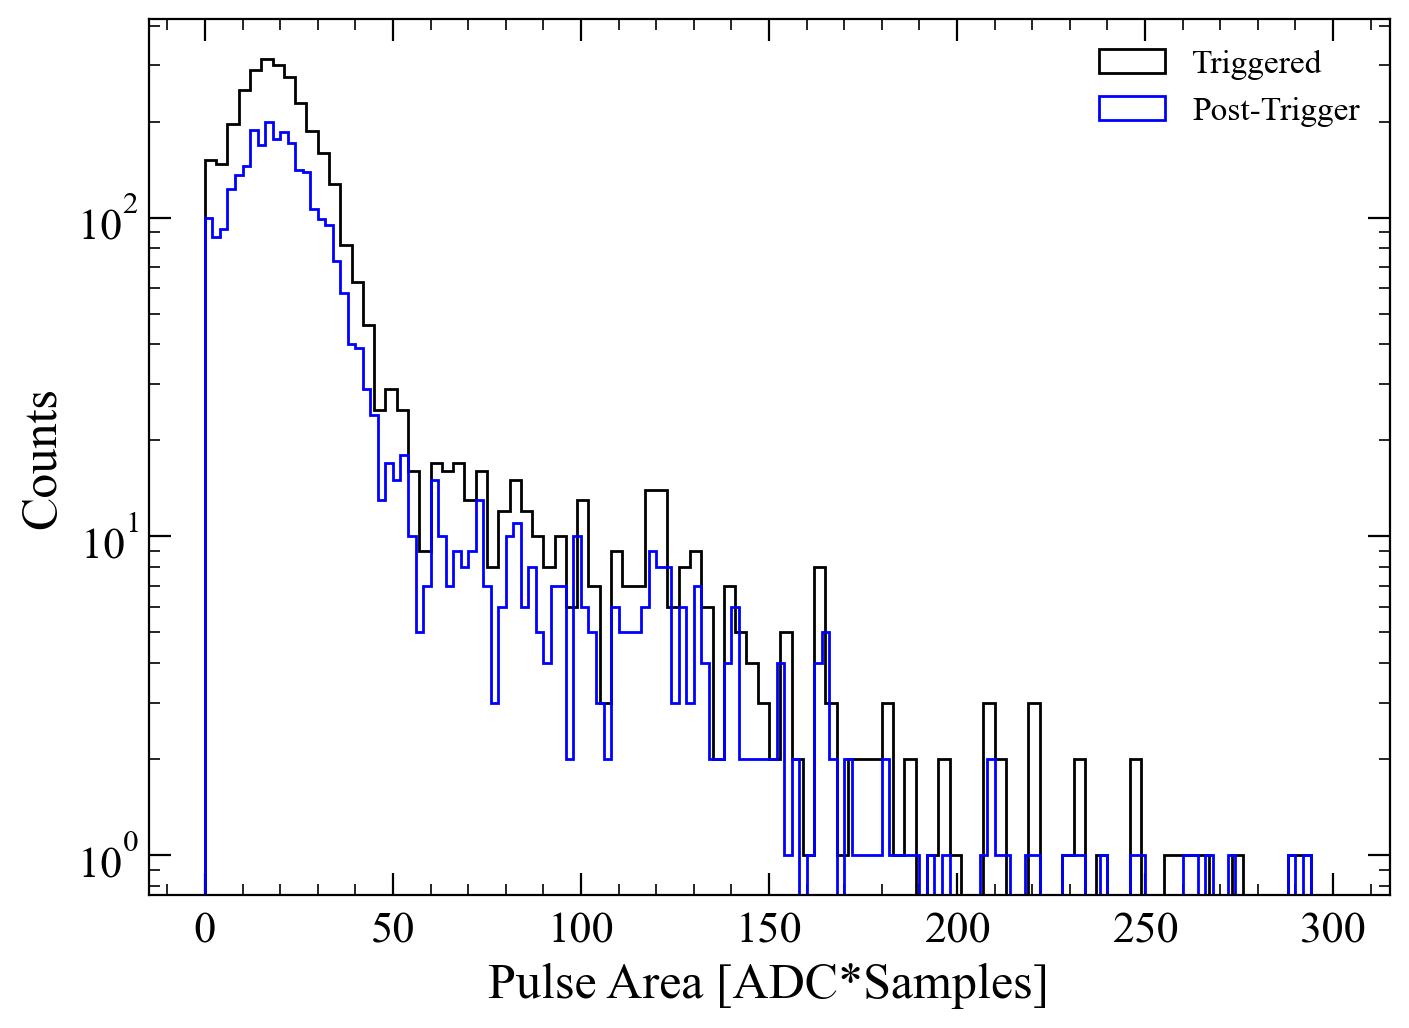

In [29]:
## ------------------------------ ##
##  PLOT THE PULSE AREA SPECTRA   ##
## ------------------------------ ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Areas_trig, bins=100, range=[0,300], histtype='step', color='black', label='Triggered')
ax.hist(Areas_posttrig, bins=150, range=[0,300], histtype='step', color='blue', label='Post-Trigger')

ax.set_xlabel('Pulse Area [ADC*Samples]')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend(frameon=False, loc='upper right', fontsize=12)

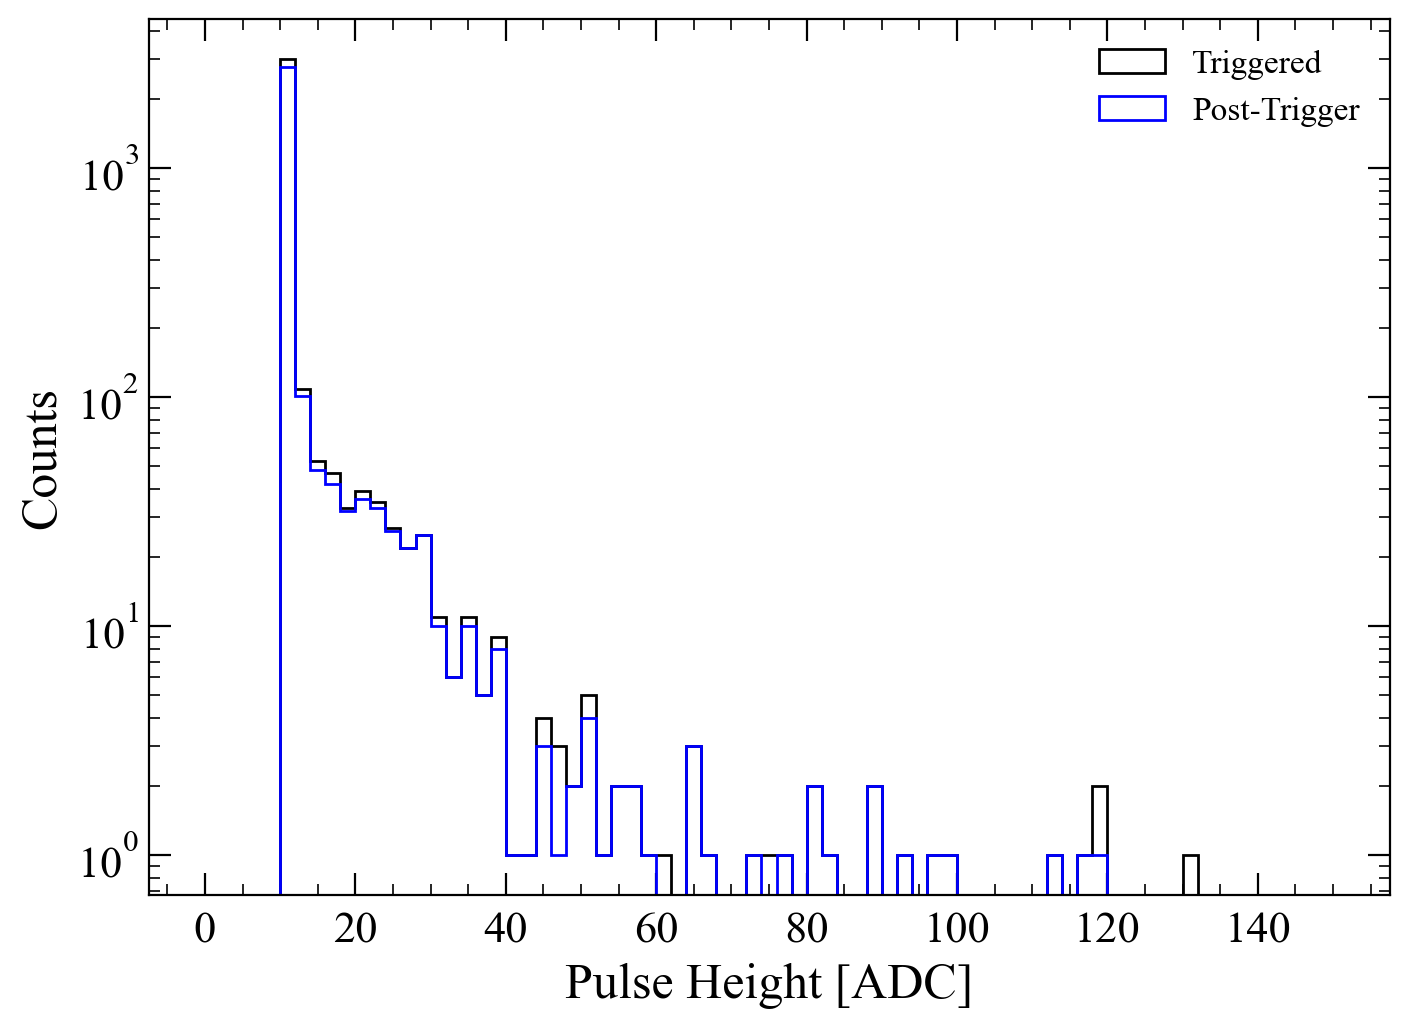

In [30]:
## ------------------------------- ##
##   PLOT THE PEAK HEIGHT SPECTRA  ##
## ------------------------------- ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Heights_trig, bins=75, range=[0,150], histtype='step', color='black', label='Triggered')
ax.hist(Heights_posttrig, bins=75, range=[0,150], histtype='step', color='blue', label='Post-Trigger')

ax.set_xlabel('Pulse Height [ADC]')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend(frameon=False, loc='upper right', fontsize=12)

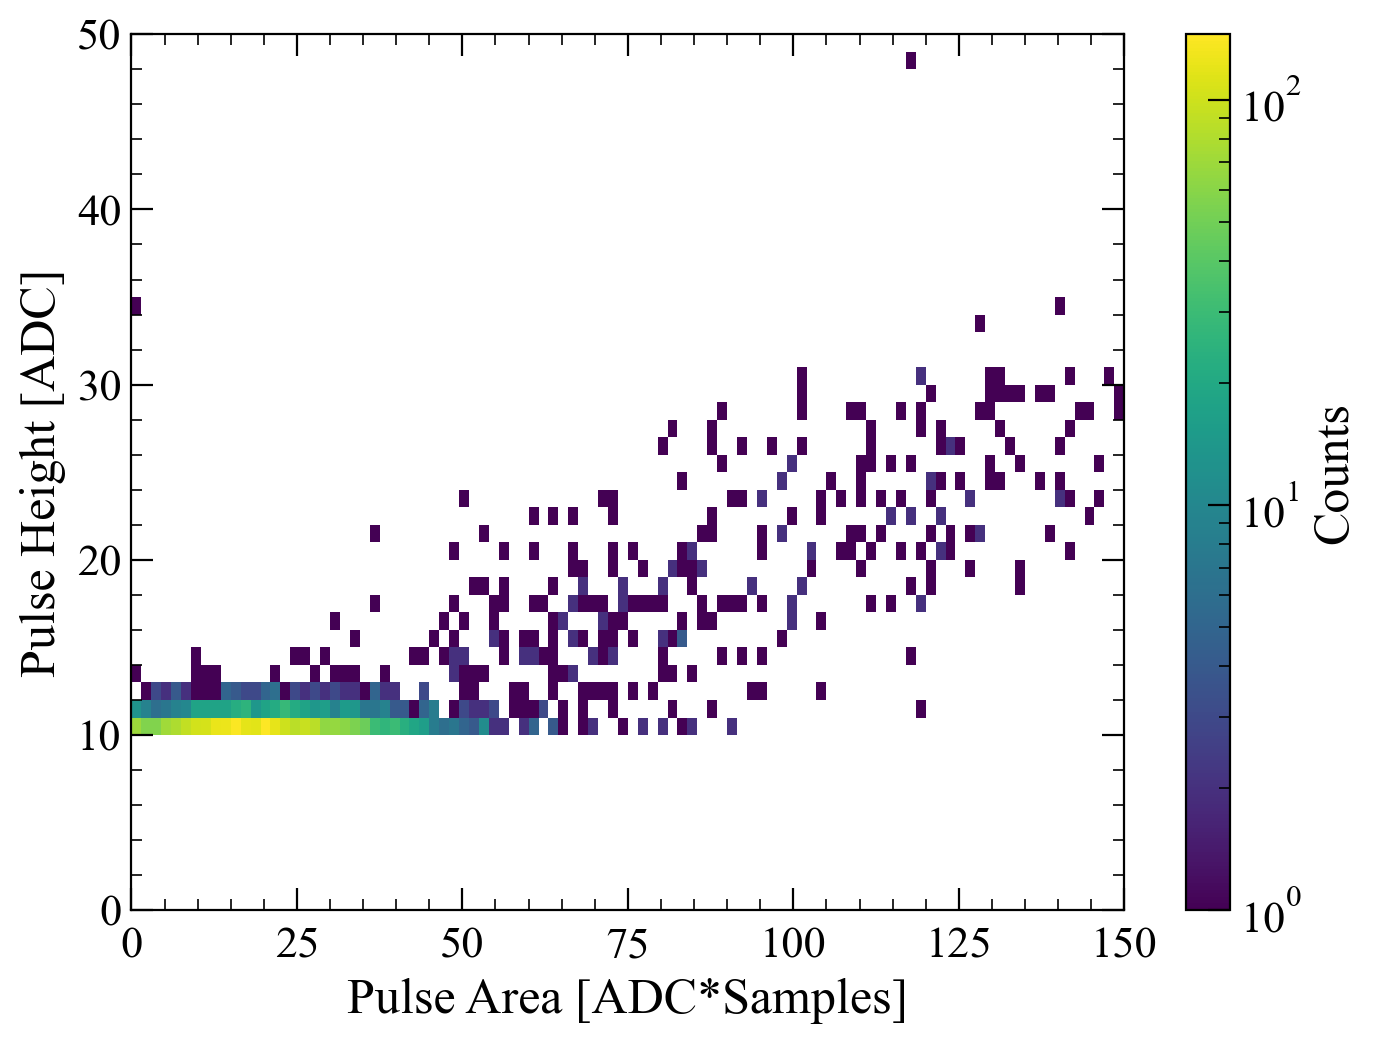

In [31]:
## ------------------------------- ##
##    PEAK HEIGHT VS PULSE AREA    ##
## ------------------------------- ##

fig, ax = plt.subplots(1,1, dpi=200)

h2 = ax.hist2d(Areas_trig, Heights_trig, bins=[100,50], range=[[0,150],[0,50]], 
               cmap='viridis', norm = matplotlib.colors.LogNorm())


ax.set_ylabel('Pulse Height [ADC]')
ax.set_xlabel('Pulse Area [ADC*Samples]')

cb = fig.colorbar(h2[3],ax=ax)
cb.set_label('Counts')

Text(0, 0.5, 'Counts')

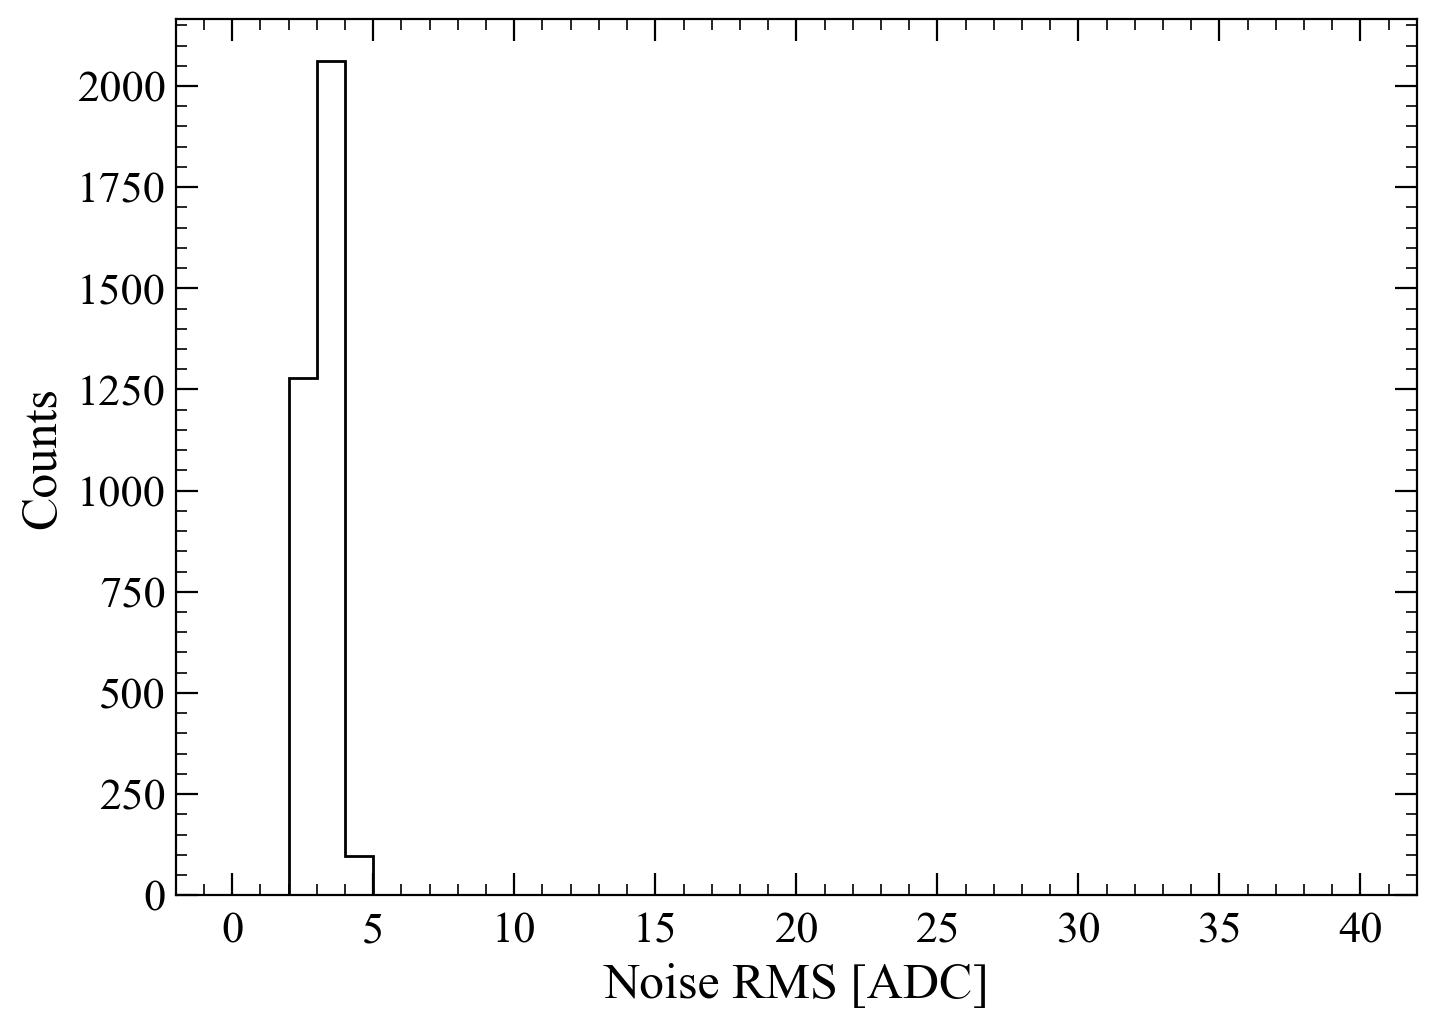

In [12]:
## ------------------------------ ##
##   PLOT THE NOISE RMS SPECTRA   ##
## ------------------------------ ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Noises, bins=40, range=[0,40], histtype='step', color='black')

ax.set_xlabel('Noise RMS [ADC]')
ax.set_ylabel('Counts')